# 0. Setup


In [1]:
# Import
!pip install -q datasets
!python -m spacy download en_core_web_sm

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, DatasetDict
import spacy
from tqdm import tqdm
from collections import Counter
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import glob
import re
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.6 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
OUT_DIR = "outputs/finals"
os.makedirs(OUT_DIR, exist_ok=True)

print("Device:", device)
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
print("Torch:", torch.__version__)

Device: cuda
GPU Name: Tesla T4
Torch: 2.8.0+cu128


In [3]:
x = torch.rand(2,3).to(device)
print("Tensor on device:", x.device)
print("Shape:", x.shape)

Tensor on device: cuda:0
Shape: torch.Size([2, 3])


# 1. Dataset (Load)

In [4]:
# Dataset variable
DATASET_NAME = "squad"
DATASET_CONFIG = None

# Load the QA dataset from HuggingFace
def load_hf_qa_dataset(name=DATASET_NAME, config=DATASET_CONFIG):
  if config is None:
    dataset = load_dataset(name)
  else:
    dataset = load_dataset(name, config)
  return dataset

# Load dataset
ds = load_hf_qa_dataset()

# Split dataset
print("Dataset loaded:", DATASET_NAME, ("(" + str(DATASET_CONFIG) + ")" if DATASET_CONFIG else ""))
print("Splits:", list(ds.keys()))
for split in ds.keys():
    print(f" - {split}: {len(ds[split])} examples")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset loaded: squad 
Splits: ['train', 'validation']
 - train: 87599 examples
 - validation: 10570 examples


In [5]:
test_size = len(ds["validation"])
train_shuffled = ds["train"].shuffle(seed=SEED)
eval_ds = train_shuffled.select(range(test_size))
train_ds = train_shuffled.select(range(test_size, len(train_shuffled)))
test_ds = ds["validation"]

ds = DatasetDict({
    "train": train_ds,
    "eval": eval_ds,
    "test": test_ds
})

print(f"Rows -> train: {len(ds['train'])}, eval: {len(ds['eval'])}, test: {len(ds['test'])}")

Rows -> train: 77029, eval: 10570, test: 10570


In [6]:
# Sampling (Optional)
USE_SAMPLES = True
SAMPLE_FRAC = 0.33
SAMPLE_SEED = 42

def maybe_sample(ds, frac, seed):
    if frac is None or frac >= 1.0:
        return ds
    n = int(len(ds) * frac)
    return ds.shuffle(seed=seed).select(range(n))

if USE_SAMPLES:
    ds = DatasetDict({
        k: maybe_sample(v, SAMPLE_FRAC, SAMPLE_SEED)
        for k, v in ds.items()
    })

print(f"USING {'SAMPLES' if USE_SAMPLES else 'FULL DATA'} -> "
      f"train: {len(ds['train'])}, eval: {len(ds['eval'])}, test: {len(ds['test'])}")

USING SAMPLES -> train: 25419, eval: 3488, test: 3488


In [7]:
# show keys and one example
train_split_name = "train" if "train" in ds else list(ds.keys())[0]
ex = ds[train_split_name][0]

print("Using splits:", list(ds.keys()))
for split in ds.keys():
    print(f" - {split}: {len(ds[split])} examples")

print("\nExample keys:", list(ex.keys()))
print("\nQuestion:", ex.get("question", "")[:200])
print("\nContext snippet:", ex.get("context", "")[:200])
print("\nAnswers:", ex.get("answers", None))

Using splits: ['train', 'eval', 'test']
 - train: 25419 examples
 - eval: 3488 examples
 - test: 3488 examples

Example keys: ['id', 'title', 'context', 'question', 'answers']

Question: How many institutes of technology in the Netherlands have converted into full-fledged universities in the past few decades?

Context snippet: In the Netherlands, four former institutes of technology have become universities over the past decades. These are the current three Technical Universities (at Delft, Eindhoven and Enschede), plus the

Answers: {'text': ['four'], 'answer_start': [20]}


# 2. Tokenizer (spaCy)

In [8]:
# Download SpaCy
try:
  nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger", "lemmatizer"])
except OSError as e:
  raise OSError(
    "spaCy model 'en_core_web_sm' not found.\n"
      "Run in a cell/shell:\n"
      "  !python -m spacy download en_core_web_sm\n"
      "and then rerun this cell."
  ) from e

def tokenize_with_offsets(text):
  if text is None:
    return [], []
  doc = nlp(str(text))
  tokens = [t.text for t in doc]
  offsets = [(t.idx, t.idx + len(t.text)) for t in doc]
  tokens_lower = [t.lower() for t in tokens]
  return tokens_lower, offsets


In [9]:
# Sanity check
split = "train" if "train" in ds else list(ds.keys())[0]
ex = ds[split][0]

context = ex["context"]
question = ex["question"]

ctx_tokens, ctx_offsets = tokenize_with_offsets(context)
q_tokens, q_offsets = tokenize_with_offsets(question)

print("Context tokens:", len(ctx_tokens))
print("Question tokens:", len(q_tokens))

# Check if random tokens are mapped correctly to substring
for i in [0, 1, 2, min(10, len(ctx_tokens)-1), min(50, len(ctx_tokens)-1)]:
  if i < 0 or i >= len(ctx_tokens):
    continue
  s, e = ctx_offsets[i]
  print(f"\nToken[{i}] = '{ctx_tokens[i]}'")
  print("Substring:", repr(context[s:e]))
  assert context[s:e].lower() == ctx_tokens[i].lower(), "Offset mismatch!"

print("\nOffset consistent")
print("\nQuestion preview:", question[:120])
print("Context preview:", context[:120])

Context tokens: 63
Question tokens: 21

Token[0] = 'in'
Substring: 'In'

Token[1] = 'the'
Substring: 'the'

Token[2] = 'netherlands'
Substring: 'Netherlands'

Token[10] = 'become'
Substring: 'become'

Token[50] = 'including'
Substring: 'including'

Offset consistent

Question preview: How many institutes of technology in the Netherlands have converted into full-fledged universities in the past few decad
Context preview: In the Netherlands, four former institutes of technology have become universities over the past decades. These are the c


# 3. Answer Normalization

These helper functions normalize the QA answers field to handle missing or malformed annotations and convert character-level answer spans into token-level spans using tokenizer offsets.

In [10]:
def normalize_answers_field(ans):
  """
  Make answers robust:
  - If it's already dict -> ensure lists exist
  - If it's missing/None -> return empty answer
  """
  # Return empty answer if none
  if ans is None:
      return {"text": [""], "answer_start": [0]}

  if isinstance(ans, str):
      import ast
      try:
          ans = ast.literal_eval(ans)
      except Exception:
          return {"text": [""], "answer_start": [0]}

  if not isinstance(ans, dict):
      return {"text": [""], "answer_start": [0]}

  texts = ans.get("text", [])
  starts = ans.get("answer_start", [])

  # list normalization
  if isinstance(texts, str):
      texts = [texts]
  if isinstance(starts, int):
      starts = [starts]

  if len(texts) == 0 or len(starts) == 0:
      return {"text": [""], "answer_start": [0]}

  return {"text": list(texts), "answer_start": list(starts)}

def char_span_to_token_span(offsets, start_char, end_char):
  """
  Convert an answer char-span [start_char, end_char) to token span indices
  Returns (start_token, end_token)
  """
  if start_char is None or end_char is None:
      return None, None
  if end_char <= start_char:
      return None, None
  if not offsets:
      return None, None

  start_tok = None
  end_tok = None

  # find first token whose span intersects/starts after start_char
  for i, (s, e) in enumerate(offsets):
      if e > start_char:   # token ends after answer starts
          start_tok = i
          break

  # find last token whose span intersects answer end
  for j in range(len(offsets) - 1, -1, -1):
      s, e = offsets[j]
      if s < end_char:     # token starts before answer ends
          end_tok = j
          break

  # if cannot find a good span returns (None, None)
  if start_tok is None or end_tok is None or end_tok < start_tok:
      return None, None

  return start_tok, end_tok

def get_first_answer_span(example, ctx_offsets):
  """
  Takes a HF QA example and offsets for context tokens
  Returns: answer_text, start_char, end_char, start_tok, end_tok
  """
  answers = normalize_answers_field(example.get("answers"))
  answer_text = answers["text"][0] if answers["text"] else ""
  start_char = answers["answer_start"][0] if answers["answer_start"] else 0


  if answer_text is None:
      answer_text = ""
  if answer_text == "":
      return "", None, None, None, None

  end_char = start_char + len(answer_text)

  start_tok, end_tok = char_span_to_token_span(ctx_offsets, start_char, end_char)

  return answer_text, start_char, end_char, start_tok, end_tok


In [11]:
# Sanity Check

split = "train" if "train" in ds else list(ds.keys())[0]
idxs = random.sample(range(len(ds[split])), k=3)

for k, idx in enumerate(idxs, 1):
  ex = ds[split][idx]
  context = ex["context"]

  ctx_tokens, ctx_offsets = tokenize_with_offsets(context)

  gold_text, s_char, e_char, s_tok, e_tok = get_first_answer_span(ex, ctx_offsets)

  print(f"\n--- Example {k} (idx={idx}) ---")
  print("Q:", ex["question"][:120])

  if gold_text == "":
      print("Gold answer: <NO ANSWER>")
      continue

  print("Gold answer:", repr(gold_text))
  print("Char span:", (s_char, e_char))
  print("Token span:", (s_tok, e_tok))

  if s_tok is None:
      print("!! Could not map to token span (offset mismatch).")
      continue

  # Reconstruct from context using token offsets
  recon_start = ctx_offsets[s_tok][0]
  recon_end = ctx_offsets[e_tok][1]
  recon_text = context[recon_start:recon_end]

  print("Reconstructed:", repr(recon_text))

  if gold_text.strip().lower() not in recon_text.strip().lower():
      print("!! Warning: reconstructed does NOT contain gold (might be tokenization edge case).")
  else:
      print("   => Span mapping looks OK")



--- Example 1 (idx=20952) ---
Q: Who initiated the scrutiny of the educational system in 1976?
Gold answer: 'James Callaghan'
Char span: (41, 56)
Token span: (7, 8)
Reconstructed: 'James Callaghan'
   => Span mapping looks OK

--- Example 2 (idx=3648) ---
Q: Who sponsored the first seven tours?
Gold answer: "Kellogg's Pop-Tarts"
Char span: (159, 178)
Token span: (39, 43)
Reconstructed: "Kellogg's Pop-Tarts"
   => Span mapping looks OK

--- Example 3 (idx=819) ---
Q: What publication does Ken Tucker work for? 
Gold answer: 'Entertainment Weekly'
Char span: (60, 80)
Token span: (11, 12)
Reconstructed: 'Entertainment Weekly'
   => Span mapping looks OK


# 4. Build Vocab

Build a frequency-based vocabulary from the training split by tokenizing both contexts and questions and counting token occurrences. It reserves special PAD/UNK tokens.
Provides encoding/decoding utilities to map between tokens and indices for model input and output.

In [12]:
# Special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

PAD_ID = 0
UNK_ID = 1

MAX_VOCAB_SIZE = 100000
MIN_FREQ = 2

def build_vocab_from_split(dataset_split, max_size=MAX_VOCAB_SIZE, min_freq=MIN_FREQ):
  counter = Counter()

  for ex in tqdm(dataset_split, desc="Building vocab"):
    ctx_toks, _ = tokenize_with_offsets(ex["context"])
    q_toks, _ = tokenize_with_offsets(ex["question"])
    counter.update(ctx_toks)
    counter.update(q_toks)

  # Keep tokens with freq >= min_freq
  tokens = [tok for tok, c in counter.items() if c >= min_freq]
  tokens.sort(key=lambda t: (-counter[t], t))


  tokens = tokens[: max_size -2] # reverse PAD/UNK

  itos = [PAD_TOKEN, UNK_TOKEN] + tokens
  stoi = {tok: i for i, tok in enumerate(itos)}

  return stoi, itos, counter

def encode(tokens, stoi):
  return [stoi.get(t, UNK_ID) for t in tokens]

def decode(ids, itos):
  out = []
  for i in ids:
    if 0 <= i < len(itos):
      out.append(itos[i])
    else:
      out.append(UNK_TOKEN)
  return out

# Build Vocab
train_split = "train" if "train" in ds else list(ds.keys())[0]

stoi, itos, vocab_counter = build_vocab_from_split(ds[train_split])

print("Vocab built")
print("Vocab size:", len(itos))
print("Most common tokens:", vocab_counter.most_common(10))

Building vocab: 100%|██████████| 25419/25419 [03:56<00:00, 107.64it/s]


Vocab built
Vocab size: 59555
Most common tokens: [('the', 257274), (',', 195179), ('of', 129167), ('.', 125645), ('and', 99107), ('in', 93687), ('to', 72186), ('a', 59058), ('"', 33902), ('-', 31713)]


In [13]:
# Sanity check
ex = ds[train_split][0]
q_toks, _ = tokenize_with_offsets(ex["question"])
ctx_toks, _ = tokenize_with_offsets(ex["context"])

q_ids = encode(q_toks, stoi)
ctx_ids = encode(ctx_toks, stoi)

print("\nQuestion tokens:", q_toks[:20])
print("Question ids   :", q_ids[:20])
print("Decoded back   :", decode(q_ids[:20], itos))

print("\nContext tokens:", ctx_toks[:20])
print("Context ids   :", ctx_ids[:20])
print("Decoded back  :", decode(ctx_ids[:20], itos))

assert PAD_ID == stoi[PAD_TOKEN]
assert UNK_ID == stoi[UNK_TOKEN]
assert len(q_ids) == len(q_toks)
assert len(ctx_ids) == len(ctx_toks)


Question tokens: ['how', 'many', 'institutes', 'of', 'technology', 'in', 'the', 'netherlands', 'have', 'converted', 'into', 'full', '-', 'fledged', 'universities', 'in', 'the', 'past', 'few', 'decades']
Question ids   : [91, 52, 4914, 4, 641, 7, 2, 2274, 37, 2224, 64, 539, 11, 21016, 723, 7, 2, 900, 378, 1483]
Decoded back   : ['how', 'many', 'institutes', 'of', 'technology', 'in', 'the', 'netherlands', 'have', 'converted', 'into', 'full', '-', 'fledged', 'universities', 'in', 'the', 'past', 'few', 'decades']

Context tokens: ['in', 'the', 'netherlands', ',', 'four', 'former', 'institutes', 'of', 'technology', 'have', 'become', 'universities', 'over', 'the', 'past', 'decades', '.', 'these', 'are', 'the']
Context ids   : [7, 2, 2274, 3, 198, 331, 4914, 4, 641, 37, 255, 723, 83, 2, 900, 1483, 5, 78, 26, 2]
Decoded back  : ['in', 'the', 'netherlands', ',', 'four', 'former', 'institutes', 'of', 'technology', 'have', 'become', 'universities', 'over', 'the', 'past', 'decades', '.', 'these',

# 5. Glove Embeddings

Download and extract pre-trained GloVe embeddings, and construct an embedding matrix aligned with the model vocabulary.
Missing tokens are randomly initialized (with zero padding for PAD)

In [14]:
EMB_DIM = 100
GLOVE_DIR = "glove"
GLOVE_FILE = f"glove.6B.{EMB_DIM}d.txt"
GLOVE_PATH = os.path.join(GLOVE_DIR, GLOVE_FILE)
GLOVE_ZIP_URL = "https://nlp.stanford.edu/data/glove.6B.zip"

os.makedirs(GLOVE_DIR, exist_ok=True)

def download_and_extract_glove():
    zip_path = os.path.join(GLOVE_DIR, "glove.6B.zip")

    if not os.path.exists(zip_path):
        print("Downloading GloVe...")

        def progress_hook(t):
            last_b = [0]

            def inner(blocks=1, block_size=1, total_size=None):
                if total_size is not None:
                    if t.total == 0:
                        t.total = total_size
                downloaded = blocks * block_size
                t.update(downloaded - last_b[0])
                last_b[0] = downloaded
            return inner

        with tqdm(unit="B", unit_scale=True, unit_divisor=1024, desc="GloVe zip") as t:
            urllib.request.urlretrieve(
                GLOVE_ZIP_URL,
                zip_path,
                reporthook=progress_hook(t)
            )

        print("Download complete")

    if not os.path.exists(GLOVE_PATH):
        print("Extracting GloVe...")
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extract(GLOVE_FILE, path=GLOVE_DIR)
        print("Extraction complete")

def load_glove_vectors(glove_path, emb_dim):
    glove = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in tqdm(f, desc="Loading GloVe"):
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] == emb_dim:
                glove[word] = vec
    return glove

def build_embedding_matrix(stoi, glove_dict, emb_dim):
    vocab_size = len(stoi)
    embedding_matrix = np.random.uniform(
        -0.05, 0.05, size=(vocab_size, emb_dim)
    ).astype(np.float32)

    embedding_matrix[PAD_ID] = np.zeros((emb_dim,), dtype=np.float32)

    hits = 0
    for token, idx in tqdm(stoi.items(), desc="Building embedding matrix"):
        if token in (PAD_TOKEN, UNK_TOKEN):
            continue
        vec = glove_dict.get(token)
        if vec is not None:
            embedding_matrix[idx] = vec
            hits += 1

    hit_rate = hits / max(1, (vocab_size - 2))
    return embedding_matrix, hit_rate


if not os.path.exists(GLOVE_PATH):
    download_and_extract_glove()

glove = load_glove_vectors(GLOVE_PATH, EMB_DIM)
embedding_matrix, hit_rate = build_embedding_matrix(stoi, glove, EMB_DIM)

print(f"GloVe vectors loaded: {len(glove)}")
print(f"Coverage (excluding PAD/UNK): {hit_rate*100:.2f}%")

GloVe zip: 822MB [04:00, 3.59MB/s] 


Download complete
Extracting GloVe...
Extraction complete


Loading GloVe: 400000it [00:06, 62488.15it/s]
Building embedding matrix: 100%|██████████| 59555/59555 [00:00<00:00, 458148.59it/s]

GloVe vectors loaded: 400000
Coverage (excluding PAD/UNK): 84.67%


In [15]:
# Sanity Check
print("Embedding matrix shape:", embedding_matrix.shape)
assert embedding_matrix.shape[0] == len(itos)
assert embedding_matrix.shape[1] == EMB_DIM
assert np.allclose(embedding_matrix[PAD_ID], 0.0)
print("Embedding matrix sanity check OK")

Embedding matrix shape: (59555, 100)
Embedding matrix sanity check OK


# 6. Dataset Prep

Transform a single SQuAD example into a training-ready record.

The processing pipeline is as follows:

1. Tokenization of the context and the question  
2. Truncation to predefined maximum lengths  
3. Conversion of tokens into vocabulary indices  
4. Computation of the answer start and end indices in token space


In [16]:
MAX_C_LEN = 400   # paper uses 600
MAX_Q_LEN = 50    # context max tokens (paper not define)

def process_example(ex, stoi):

  context = ex["context"]
  question = ex["question"]

  # tokenize
  c_toks, c_offsets = tokenize_with_offsets(context)
  q_toks, _ = tokenize_with_offsets(question)

  # truncate tokens (keep offsets aligned for context)
  c_toks_tr = c_toks[:MAX_C_LEN]
  q_toks_tr = q_toks[:MAX_Q_LEN]
  c_offsets_tr = c_offsets[:MAX_C_LEN]

  # numericalize
  c_ids = encode(c_toks_tr, stoi)
  q_ids = encode(q_toks_tr, stoi)

  # answer span (if any)
  answer = normalize_answers_field(ex.get("answers"))
  gold_text = answer["text"][0] if answer["text"] else ""
  gold_start_char = answer["answer_start"][0] if answer["answer_start"] else 0

  has_answer = 1 if (gold_text is not None and str(gold_text).strip() != "") else 0

  if has_answer == 0:
    # convection: point to PAD (or 0)
    start_tok, end_tok = 0, 0
  else:
    end_char = gold_start_char + len(gold_text)
    start_tok, end_tok = char_span_to_token_span(c_offsets_tr, gold_start_char, end_char)

    if start_tok is None or end_tok is None:
      has_answer = 0
      start_tok, end_tok = 0, 0

  return {
    "context_ids": c_ids,
    "question_ids": q_ids,
    "start": start_tok,
    "end": end_tok,
    "has_answer": has_answer
  }

In [17]:
# Torch Dataset
class QADataset(Dataset):
  def __init__(self, hf_split, stoi):
    self.data = hf_split
    self.stoi = stoi

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    ex = self.data[idx]
    return process_example(ex, self.stoi)

In [18]:
# implement batch collation
def pad_1d(seqs, pad_value=PAD_ID):
  max_len = max(len(s) for s in seqs)
  out = torch.full((len(seqs), max_len), pad_value, dtype=torch.long)
  mask = torch.zeros((len(seqs), max_len), dtype=torch.bool)  # True where real token
  for i, s in enumerate(seqs):
    out[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    mask[i, :len(s)] = True
  return out, mask

def qa_collate(batch):
  c_seqs = [b["context_ids"] for b in batch]
  q_seqs = [b["question_ids"] for b in batch]

  context_ids, context_mask = pad_1d(c_seqs)
  question_ids, question_mask = pad_1d(q_seqs)

  start = torch.tensor([b["start"] for b in batch], dtype=torch.long)
  end = torch.tensor([b["end"] for b in batch], dtype=torch.long)
  has_answer = torch.tensor([b["has_answer"] for b in batch], dtype=torch.long)

  return {
    "context_ids": context_ids.to(device),
    "context_mask": context_mask.to(device),
    "question_ids": question_ids.to(device),
    "question_mask": question_mask.to(device),
    "start": start.to(device),
    "end": end.to(device),
    "has_answer": has_answer.to(device)
  }

# 7. Dataloader

In [19]:
# Dataloader
BATCH_SIZE = 32

train_ds = QADataset(ds["train"], stoi)
eval_ds = QADataset(ds["eval"], stoi)
test_ds = QADataset(ds["test"], stoi)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=qa_collate)
eval_loader  = DataLoader(eval_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=qa_collate)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=qa_collate)

batch = next(iter(train_loader))

print("context_ids:", batch["context_ids"].shape)
print("question_ids:", batch["question_ids"].shape)
print("start:", batch["start"].shape, "end:", batch["end"].shape)
print("has_answer:", batch["has_answer"].shape)

# range check: start/end must be within context length
B, C = batch["context_ids"].shape
assert torch.all(batch["start"] < C), "start out of range"
assert torch.all(batch["end"] < C), "end out of range"
assert torch.all(batch["start"] <= batch["end"]), "start > end"

print(" => DataLoader sanity check OK")

context_ids: torch.Size([32, 333])
question_ids: torch.Size([32, 22])
start: torch.Size([32]) end: torch.Size([32])
has_answer: torch.Size([32])
 => DataLoader sanity check OK


# 8. Model

### 8.A Masking utilities (masked_fill_logits, masked_softmax)

These functions correctly handle padding and boolean masks when applying a softmax or when preventing the model from selecting invalid positions.

- masked_fill_logits: sets logits to -1e30 (≈ −∞) where mask=False.  
  This is useful before an argmax or a softmax, ensuring that padding positions are never selected.

- masked_softmax: computes a softmax that assigns probability mass only to valid positions.  
  The renormalization step prevents the probabilities from summing to a value different from 1 due to numerical issues.

In [20]:
def masked_fill_logits(logits: torch.Tensor, mask: torch.Tensor, fill: float = -1e30) -> torch.Tensor:
    mask = mask.to(torch.bool)
    return logits.masked_fill(~mask, fill)

def masked_softmax(logits: torch.Tensor, mask: torch.Tensor, dim: int = -1, eps: float = 1e-9) -> torch.Tensor:
    mask = mask.to(torch.bool)
    masked_logits = logits.masked_fill(~mask, -1e30)
    probs = F.softmax(masked_logits, dim=dim)
    probs = probs * mask.to(probs.dtype)
    probs = probs / (probs.sum(dim=dim, keepdim=True) + eps)
    return probs

### 8.B LockedDropout (dropout “bloccato” nel tempo)

This dropout applies the same mask to all time steps of the sequence (the mask is shared along the T dimension).

Input: x with shape [B, T, D]
Mask: [B, 1, D] (then broadcast across T)

- B = batch size
- T = sequence length (in tokens)
- D = embedding size



In [21]:
class LockedDropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = float(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D]
        if (not self.training) or self.p == 0.0:
            return x
        keep = 1.0 - self.p
        mask = x.new_empty(x.size(0), 1, x.size(2)).bernoulli_(keep)
        mask = mask / keep
        return x * mask

### 8.C Highway Maxout Network (HMN)

The HMN takes as input:
* U: document memory [B, m, 2l] (one vector u_t for each position t)
* h: decoder state [B, l]
* u_s_prev, u_e_prev: memory vectors at the positions selected in the previous iteration [B, 2l]

and produces:

* scores: [B, m], one score for each document position.

**Mathematical idea (from the paper):**

1. it builds a vector r = tanh(W_D [h; u_s; u_e]) in R^l
2. for each position t, it concatenates [u_t; r] and applies two maxout layers (m1, m2)
3. it outputs a final scalar score via a maxout over [m1; m2]

**Why it is needed:**

* The decoder must assign a score to every document position in a highly expressive way.
* Maxout increases model capacity without significantly increasing depth.


In [22]:
class HighwayMaxout(nn.Module):
    """
    U: [B, m, 2l]
    h: [B, l]
    u_s_prev/u_e_prev: [B, 2l]
    output scores: [B, m]
    """
    def __init__(self, l: int, pool_size: int = 16):
        super().__init__()
        self.l = int(l)
        self.p = int(pool_size)

        self.WD = nn.Linear(5 * l, l)
        self.W1 = nn.Linear(3 * l, self.p * l)
        self.W2 = nn.Linear(l, self.p * l)
        self.W3 = nn.Linear(2 * l, self.p * 1)

    def _maxout(self, x: torch.Tensor, out_dim: int) -> torch.Tensor:
        N = x.size(0)
        x = x.view(N, self.p, out_dim)
        return x.max(dim=1).values

    def forward(self, U: torch.Tensor, h: torch.Tensor, u_s_prev: torch.Tensor, u_e_prev: torch.Tensor) -> torch.Tensor:
        B, m, _ = U.shape
        l = self.l

        r = torch.tanh(self.WD(torch.cat([h, u_s_prev, u_e_prev], dim=1)))

        r_exp = r.unsqueeze(1).expand(B, m, l)
        x1 = torch.cat([U, r_exp], dim=2)
        x1 = x1.reshape(B * m, 3 * l)

        m1 = self._maxout(self.W1(x1), out_dim=l)
        m2 = self._maxout(self.W2(m1), out_dim=l)

        x3 = torch.cat([m1, m2], dim=1)
        out = self._maxout(self.W3(x3), out_dim=1)
        return out.view(B, m)


### 8.D DCN — Encoder + Coattention + Fusion

This component builds the document memory U (shape [B, m, 2l]) that is later consumed by the dynamic decoder.

**Pipeline:**

1. Embedding: context_ids → D_emb, question_ids → Q_emb
2. Shared LSTM encoder (unidirectional) produces:

   * D_enc ∈ R^{B×m×l}
   * Q0 ∈ R^{B×n×l}
3. Sentinel: adds d_∅ and q_∅ as extra tokens (lengths m+1 and n+1)
4. Question projection: Q = tanh(W_Q Q0)
5. Coattention:

   * L = D Q^T with shape [B, m+1, n+1]
   * A_Q = softmax(L) normalized over the document dimension
   * A_D = softmax(L^T) normalized over the question dimension
   * C_Q = D^T A_Q (document memory “as seen from the question”) → [B, n+1, l]
   * C_D = A_D^T [Q; C_Q] → [B, m+1, 2l]

6. Fusion BiLSTM over [d_t; c_t^D] (real tokens only, sentinel excluded)
   → U ∈ R^{B×m×2l}

The resulting U is the final question-guided representation of the document.


In [23]:
class DCN(nn.Module):
    """
      - shared unidirectional LSTM encoder
      - sentinel vectors appended
      - question projection
      - coattention encoder (AQ, AD, CQ, CD)
      - fusion BiLSTM -> U
    """
    def __init__(self,
                 embedding_matrix,
                 pad_id: int,
                 hidden_size: int = 200,
                 dropout: float = 0.2,
                 max_decoder_iters: int = 4,
                 hmn_pool_size: int = 16,
                 freeze_emb: bool = False):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape
        self.pad_id = int(pad_id)
        self.l = int(hidden_size)
        self.max_decoder_iters = int(max_decoder_iters)

        # Embeddings
        self.emb = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=freeze_emb,
            padding_idx=self.pad_id
        )
        self.drop = LockedDropout(dropout)

        # Shared encoder (unidirectional LSTM)
        self.enc = nn.LSTM(
            input_size=emb_dim,
            hidden_size=self.l,
            batch_first=True,
            bidirectional=False
        )

        # Sentinel vectors d_∅ and q_∅
        self.d_sentinel = nn.Parameter(torch.zeros(self.l))
        self.q_sentinel = nn.Parameter(torch.zeros(self.l))
        nn.init.normal_(self.d_sentinel, mean=0.0, std=0.02)
        nn.init.normal_(self.q_sentinel, mean=0.0, std=0.02)

        # Question projection Q = tanh(WQ Q0 + bQ)
        self.q_proj = nn.Linear(self.l, self.l)

        # Fusion BiLSTM
        self.fuse = nn.LSTM(
            input_size=3 * self.l,
            hidden_size=self.l,
            batch_first=True,
            bidirectional=True
        )

        self.dec = nn.LSTMCell(input_size=4 * self.l, hidden_size=self.l)
        self.hmn_start = HighwayMaxout(l=self.l, pool_size=hmn_pool_size)
        self.hmn_end   = HighwayMaxout(l=self.l, pool_size=hmn_pool_size)

    def _encode_and_coattend(self, context_ids, context_mask, question_ids, question_mask):

        B, m = context_ids.shape
        _, n = question_ids.shape
        l = self.l

        # Embedding + LockedDropout
        D_emb = self.drop(self.emb(context_ids))
        Q_emb = self.drop(self.emb(question_ids))

        # Shared encoder LSTM
        D_enc, _ = self.enc(D_emb)
        Q0, _    = self.enc(Q_emb)
        D_enc = self.drop(D_enc)
        Q0    = self.drop(Q0)

        # Append sentinel
        d_s = self.d_sentinel.view(1, 1, l).expand(B, 1, l)
        q_s = self.q_sentinel.view(1, 1, l).expand(B, 1, l)
        D   = torch.cat([D_enc, d_s], dim=1)
        Q0  = torch.cat([Q0, q_s], dim=1)

        # Masks
        D_mask = torch.cat([context_mask, torch.ones(B, 1, device=context_mask.device, dtype=torch.bool)], dim=1)   # [B, m+1]
        Q_mask = torch.cat([question_mask, torch.ones(B, 1, device=question_mask.device, dtype=torch.bool)], dim=1) # [B, n+1]

        # Question projection
        Q = torch.tanh(self.q_proj(Q0))

        # Coattention
        # L = D Q^T -> [B, m+1, n+1]
        L = torch.bmm(D, Q.transpose(1, 2))


        mask_L = D_mask.unsqueeze(2) & Q_mask.unsqueeze(1)
        # AQ = softmax(L)
        AQ = masked_softmax(L, mask_L, dim=1)

        # AD = softmax(L^T)
        LT = L.transpose(1, 2)
        mask_LT = Q_mask.unsqueeze(2) & D_mask.unsqueeze(1)
        AD = masked_softmax(LT, mask_LT, dim=1)

        # CQ = D^T AQ
        CQ = torch.bmm(D.transpose(1, 2), AQ).transpose(1, 2)

        # CD = AD^T [Q; CQ]
        QCQ = torch.cat([Q, CQ], dim=2)
        CD  = torch.bmm(AD.transpose(1, 2), QCQ)

        # Fusion BiLSTM
        D_real  = D[:, :m, :]
        CD_real = CD[:, :m, :]
        fuse_in = torch.cat([D_real, CD_real], dim=2)

        U, _ = self.fuse(fuse_in)
        U = self.drop(U)
        return U

    def forward(self, context_ids, context_mask, question_ids, question_mask, return_all_iters=False):
        # forward next
        raise NotImplementedError("Next Cell")


### 8.E DCN — Dynamic Decoder (paper §2.3–2.4)

Once the document memory U ∈ R^{B×m×2l} is obtained, the DCN uses an iterative decoder to predict the answer span.

Initialization:

* s₀ = 0, e₀ = 0 (for each example in the batch)
* h₀ = 0, c₀ = 0 (LSTMCell hidden and cell states)

Iteration i:

1. Retrieve u_{s_{i-1}} and u_{e_{i-1}} from the memory U (via gather at the selected positions)
2. Update the decoder state:
   [
   h_i, c_i = \mathrm{LSTMCell}([u_{s_{i-1}}; u_{e_{i-1}}], (h_{i-1}, c_{i-1}))
   ]
3. Compute start and end logits over all document positions t:

   * start_logits[t] = HMN_start(U, h_i, u_s_prev, u_e_prev)
   * end_logits[t]   = HMN_end(...)
4. Apply the context_mask to prevent selecting padding positions
5. s_i = argmax(start_logits), e_i = argmax(end_logits)
6. If the pair (s, e) no longer changes, the decoder stops (“convergence”)

Output:

* either the final pair of logits (default behavior)
* or the list of logits from all iterations (return_all_iters=True)

In [24]:
def dcn_forward_with_dynamic_decoder(self, context_ids, context_mask, question_ids, question_mask, return_all_iters=False):
    B, m = context_ids.shape
    l = self.l
    device = context_ids.device

    U = self._encode_and_coattend(context_ids, context_mask, question_ids, question_mask)  # [B, m, 2l]

    # Init decoder
    s_prev = torch.zeros(B, dtype=torch.long, device=device)
    e_prev = torch.zeros(B, dtype=torch.long, device=device)
    h = torch.zeros(B, l, device=device)
    c = torch.zeros(B, l, device=device)

    start_logits_list, end_logits_list = [], []

    for _ in range(self.max_decoder_iters):

        u_s_prev = U[torch.arange(B, device=device), s_prev]
        u_e_prev = U[torch.arange(B, device=device), e_prev]

        # LSTMCell input: [u_s; u_e] -> [B, 4l]
        dec_in = torch.cat([u_s_prev, u_e_prev], dim=1)
        h, c = self.dec(dec_in, (h, c))

        # HMN scores (logits) per all position
        start_logits = self.hmn_start(U, h, u_s_prev, u_e_prev)
        end_logits   = self.hmn_end(U,   h, u_s_prev, u_e_prev)

        # Mask padding
        start_logits = masked_fill_logits(start_logits, context_mask)
        end_logits   = masked_fill_logits(end_logits,   context_mask)

        start_logits_list.append(start_logits)
        end_logits_list.append(end_logits)

        # Update predict
        s_new = torch.argmax(start_logits, dim=1)
        e_new = torch.argmax(end_logits, dim=1)

        # Convergence
        if (s_new == s_prev).all() and (e_new == e_prev).all():
            s_prev, e_prev = s_new, e_new
            break

        s_prev, e_prev = s_new, e_new

    if return_all_iters:
        return start_logits_list, end_logits_list
    return start_logits_list[-1], end_logits_list[-1]


DCN.forward = dcn_forward_with_dynamic_decoder

In [25]:
# Sanity Check Forward
model = DCN(
    embedding_matrix,
    pad_id=PAD_ID,
    hidden_size=128,
    dropout=0.2,
    max_decoder_iters=4,
    freeze_emb=False
).to(device)

model.train()

batch = next(iter(train_loader))
start_logits, end_logits = model(
    batch["context_ids"], batch["context_mask"],
    batch["question_ids"], batch["question_mask"]
)

print("start_logits:", start_logits.shape)
print("end_logits  :", end_logits.shape)

B, C = batch["context_ids"].shape
assert start_logits.shape == (B, C)
assert end_logits.shape == (B, C)
assert torch.isfinite(start_logits).all(), "NaN/Inf in start_logits"
assert torch.isfinite(end_logits).all(), "NaN/Inf in end_logits"

print("✅ Forward sanity check OK")


start_logits: torch.Size([32, 281])
end_logits  : torch.Size([32, 281])
✅ Forward sanity check OK


# 8. Loss

The model loss is the sum of two CrossEntropy terms:

* one for the start position of the answer
* one for the end position

Each term compares the distribution predicted by the model with the correct token index in the context.

In [26]:
# Instantiate model
model = DCN(
    embedding_matrix,
    pad_id=PAD_ID,
    hidden_size=200,      # same as paper
    dropout=0.2,
    max_decoder_iters=4,
    freeze_emb=True      # same as paper
).to(device)

# Optimizer
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Loss for start/end positions
ce_loss = nn.CrossEntropyLoss()

def compute_span_loss(start_logits, end_logits, start_true, end_true, mode="sum"):

    if isinstance(start_logits, (list, tuple)):
        losses = []
        for s_log, e_log in zip(start_logits, end_logits):
            losses.append(ce_loss(s_log, start_true) + ce_loss(e_log, end_true))
        loss = torch.stack(losses).sum()
        if mode == "mean":
            loss = loss / max(1, len(losses))
        return loss

    return ce_loss(start_logits, start_true) + ce_loss(end_logits, end_true)

model.train()
batch = next(iter(train_loader))

# return all iterations
start_logits_list, end_logits_list = model(
    batch["context_ids"], batch["context_mask"],
    batch["question_ids"], batch["question_mask"],
    return_all_iters=True
)

loss = compute_span_loss(
    start_logits_list, end_logits_list,
    batch["start"], batch["end"],
    mode="sum"
)

optimizer.zero_grad()
loss.backward()

# gradient clipping
CLIP = 5.0
torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

optimizer.step()

print("One train step done (cumulative loss across decoder iters)")
print("Loss:", float(loss.detach().cpu()))
print("Num iters:", len(start_logits_list))

One train step done (cumulative loss across decoder iters)
Loss: 38.164302825927734
Num iters: 4


In [27]:
# Sanity Check
model.eval()
with torch.no_grad():
    batch = next(iter(train_loader))
    start_logits, end_logits = model(
        batch["context_ids"], batch["context_mask"],
        batch["question_ids"], batch["question_mask"]
    )

    # Verify predicted indices fall within non-pad region
    pred_start = start_logits.argmax(dim=1)
    pred_end = end_logits.argmax(dim=1)
    ok_start = batch["context_mask"][torch.arange(pred_start.size(0), device=device), pred_start].float().mean().item()
    ok_end   = batch["context_mask"][torch.arange(pred_end.size(0), device=device), pred_end].float().mean().item()

print(f"Pred start on real token: {ok_start*100:.1f}%")
print(f"Pred end   on real token: {ok_end*100:.1f}%")
print("Sanity checks completed")


Pred start on real token: 100.0%
Pred end   on real token: 100.0%
Sanity checks completed


In [28]:
# Load Checkpoint if available

import os
import torch

CHECKPOINT_PATH = OUT_DIR + "/dcn_base/best_dcn_base.pt"
SKIP_TRAINING = False

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found checkpoint: {CHECKPOINT_PATH}")

    # build model architecture
    model = DCN(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=0.2,
        max_decoder_iters=4,
        freeze_emb=True
    ).to(device)

    # Load checkpoint
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

    model.load_state_dict(state_dict)  # strict=True by default
    model.eval()

    SKIP_TRAINING = True
    print("Model loaded. Training will be skipped.")
else:
    print("No checkpoint found – training will run normally.")


No checkpoint found – training will run normally.


# 9. Evaluate Function

In [29]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()

    total_em = 0.0
    total_f1 = 0.0
    total_loss = 0.0
    total_examples = 0
    count = 0

    for batch in tqdm(data_loader, desc="Evaluating"):

        # move to device
        context_ids   = batch["context_ids"].to(device)
        context_mask  = batch["context_mask"].to(device)
        question_ids  = batch["question_ids"].to(device)
        question_mask = batch["question_mask"].to(device)
        start_true    = batch["start"].to(device)
        end_true      = batch["end"].to(device)

        start_logits, end_logits = model(
            context_ids, context_mask,
            question_ids, question_mask,
            return_all_iters=True
        )

        loss = compute_span_loss(
            start_logits, end_logits,
            batch["start"], batch["end"],
            ce_loss=ce_loss,
            mode="sum"
        )

        bs = batch["context_ids"].size(0)
        total_loss += float(loss.item()) * bs
        total_examples += bs

        start_logits = start_logits[-1]
        end_logits   = end_logits[-1]

        start_pred = torch.argmax(start_logits, dim=1)
        end_pred   = torch.argmax(end_logits, dim=1)

        # Compute EM and F1
        for s_p, e_p, s_t, e_t in zip(start_pred, end_pred, start_true, end_true):
            s_p, e_p = int(s_p), int(e_p)
            s_t, e_t = int(s_t), int(e_t)

            if e_p < s_p:
                e_p = s_p

            # EM
            if s_p == s_t and e_p == e_t:
                total_em += 1.0

            # F1
            pred_tokens = set(range(s_p, e_p + 1))
            true_tokens = set(range(s_t, e_t + 1))

            inter = len(pred_tokens & true_tokens)
            if inter == 0:
                f1 = 0.0
            else:
                precision = inter / len(pred_tokens)
                recall    = inter / len(true_tokens)
                f1 = 2 * precision * recall / (precision + recall)

            total_f1 += f1
            count += 1

    model.train()

    em = 100.0 * total_em / max(1, count)
    f1 = 100.0 * total_f1 / max(1, count)
    final_loss = total_loss / max(1, total_examples)
    return final_loss, em, f1


# 10. Training

In this section, the training loop is implemented.

For each epoch, the model:

* processes the training batches
* computes the loss
* updates the weights via backpropagation
* applies gradient clipping to prevent exploding gradients

After each epoch, the loss is evaluated on the validation set.
The best-performing model is saved, and training automatically stops if performance does not improve for a predefined number of epochs.

In [30]:
def compute_span_loss(start_logits, end_logits, start_true, end_true, ce_loss, mode="sum"):
    if isinstance(start_logits, (list, tuple)):
        losses = []
        for s_log, e_log in zip(start_logits, end_logits):
            losses.append(ce_loss(s_log, start_true) + ce_loss(e_log, end_true))
        loss = torch.stack(losses).sum()
        if mode == "mean":
            loss = loss / max(1, len(losses))
        return loss

    return ce_loss(start_logits, start_true) + ce_loss(end_logits, end_true)


def train_one_epoch(model, loader, optimizer, ce_loss, clip=5.0, log_every=500, epoch_idx=0):
    model.train()
    running = 0.0
    seen = 0

    pbar = tqdm(loader, desc=f"Train epoch {epoch_idx+1}", leave=True)
    for step, batch in enumerate(pbar, 1):
        # forward
        start_logits, end_logits = model(
            batch["context_ids"], batch["context_mask"],
            batch["question_ids"], batch["question_mask"],
            return_all_iters=True
        )

        # loss
        loss = compute_span_loss(
            start_logits, end_logits,
            batch["start"], batch["end"],
            ce_loss=ce_loss,
            mode="sum"
        )

        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        bs = batch["context_ids"].size(0)
        running += float(loss.item()) * bs
        seen += bs

        avg_loss = running / max(1, seen)
        pbar.set_postfix(loss=f"{avg_loss:.4f}")

        if log_every and step % log_every == 0:
            pbar.write(f"  step {step}: avg_loss={avg_loss:.4f}")

    return running / max(1, seen)


def train_dcn(
    model,
    train_loader,
    eval_loader,
    device,
    out_dir,
    stoi=None,
    itos=None,
    emb_dim=None,
    max_c_len=None,
    max_q_len=None,
    seed=None,
    epochs=5,
    lr=1e-3,
    clip=5.0,
    log_every=500,
    early_stop=True,
    patience=3,
    min_delta=1e-4,
    skip_training=False,
    best_filename="best_dcn.pt",
):

    os.makedirs(out_dir, exist_ok=True)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()

    best_eval = float("inf")
    best_path = os.path.join(out_dir, best_filename)

    history = {
        "train_loss": [],
        "eval_loss": [],
        "eval_em": [],
        "eval_f1": [],
    }
    epochs_no_improve = 0

    if skip_training:
        print("Skipping training (checkpoint already loaded)")
        return history, best_path, best_eval

    for epoch in range(epochs):
        # train
        train_loss = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            ce_loss=ce_loss,
            clip=clip,
            log_every=log_every,
            epoch_idx=epoch
        )


        # EM/F1
        eval_loss_val, eval_em, eval_f1 = evaluate(model, eval_loader, device)

        history["train_loss"].append(train_loss)
        history["eval_loss"].append(eval_loss_val)
        history["eval_em"].append(eval_em)
        history["eval_f1"].append(eval_f1)

        print(
            f"\nEpoch {epoch+1}/{epochs} | "
            f"train_loss={train_loss:.4f} | eval_loss={eval_loss_val:.4f} | "
            f"EM={eval_em:.2f}% | F1={eval_f1:.2f}%"
        )

        # early stopping
        improved = (best_eval - eval_loss_val) > min_delta

        if improved:
            best_eval = eval_loss_val
            epochs_no_improve = 0

            torch.save({
                "model_state_dict": model.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "emb_dim": emb_dim,
                "hidden_size": getattr(model, "hidden_size", None),
                "num_decoder_iters": getattr(model, "num_decoder_iters", None),
                "max_c_len": max_c_len,
                "max_q_len": max_q_len,
                "seed": seed,
                "best_eval_loss": best_eval,
                "history": history,
            }, best_path)

            print(f"Saved best model to: {best_path} (eval_loss={best_eval:.4f})")

        else:
            epochs_no_improve += 1
            print(f"No improvement. epochs_no_improve={epochs_no_improve}/{patience}")

            if early_stop and epochs_no_improve >= patience:
                print(f"Early stopping triggered (best eval_loss={best_eval:.4f}).")
                break

    return history, best_path, best_eval

In [31]:
EPOCHS = 5
LR = 1e-3
CLIP = 5.0
LOG_EVERY = 500  # batches

# Early stopping settings
EARLY_STOP = True
PATIENCE = 3          # stop after this many epochs without improvement
MIN_DELTA = 1e-4      # minimum improvement to count as better

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
ce_loss = nn.CrossEntropyLoss()

history_base, best_path_base, best_eval_base = train_dcn(
    model=model,
    train_loader=train_loader,
    eval_loader=eval_loader,
    device=device,
    out_dir=OUT_DIR + "/dcn_base",
    stoi=stoi,
    itos=itos,
    emb_dim=EMB_DIM,
    max_c_len=MAX_C_LEN,
    max_q_len=MAX_Q_LEN,
    seed=SEED,
    epochs=EPOCHS,
    lr=LR,
    clip=CLIP,
    log_every=LOG_EVERY,
    early_stop=EARLY_STOP,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    skip_training=SKIP_TRAINING,
    best_filename="best_dcn_base.pt"
)

Train epoch 1:  63%|██████▎   | 500/795 [04:09<02:19,  2.12it/s, loss=16.2521]

  step 500: avg_loss=16.2521


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 1/5 | train_loss=15.3924 | eval_loss=13.1023 | EM=10.58% | F1=17.27%
Saved best model to: outputs/finals/dcn_base/best_dcn_base.pt (eval_loss=13.1023)


Train epoch 2:  63%|██████▎   | 500/795 [04:08<02:24,  2.04it/s, loss=12.9887]

  step 500: avg_loss=12.9887


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 2/5 | train_loss=12.8163 | eval_loss=11.6267 | EM=17.75% | F1=25.59%
Saved best model to: outputs/finals/dcn_base/best_dcn_base.pt (eval_loss=11.6267)


Train epoch 3:  63%|██████▎   | 500/795 [04:05<02:22,  2.07it/s, loss=11.5897]

  step 500: avg_loss=11.5897


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 3/5 | train_loss=11.3377 | eval_loss=9.7796 | EM=26.58% | F1=38.19%
Saved best model to: outputs/finals/dcn_base/best_dcn_base.pt (eval_loss=9.7796)


Train epoch 4:  63%|██████▎   | 500/795 [04:07<02:30,  1.95it/s, loss=9.7981] 

  step 500: avg_loss=9.7981


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]



Epoch 4/5 | train_loss=9.6218 | eval_loss=8.2596 | EM=34.29% | F1=48.73%
Saved best model to: outputs/finals/dcn_base/best_dcn_base.pt (eval_loss=8.2596)


Train epoch 5:  63%|██████▎   | 500/795 [04:05<02:23,  2.05it/s, loss=8.5011]

  step 500: avg_loss=8.5011


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch 5/5 | train_loss=8.5143 | eval_loss=7.7887 | EM=35.95% | F1=51.23%
Saved best model to: outputs/finals/dcn_base/best_dcn_base.pt (eval_loss=7.7887)


In questa sezione viene implementato il ciclo di training.

Per ogni epoca il modello:

* elabora i batch di training
* calcola la loss
* aggiorna i pesi tramite backpropagation
* applica gradient clipping per evitare esplosioni del gradiente

Dopo ogni epoca viene valutata la loss sul set di validazione.
Il modello migliore viene salvato, e il training si interrompe automaticamente se la performance smette di migliorare per un numero prefissato di epoche.

# 11. Results

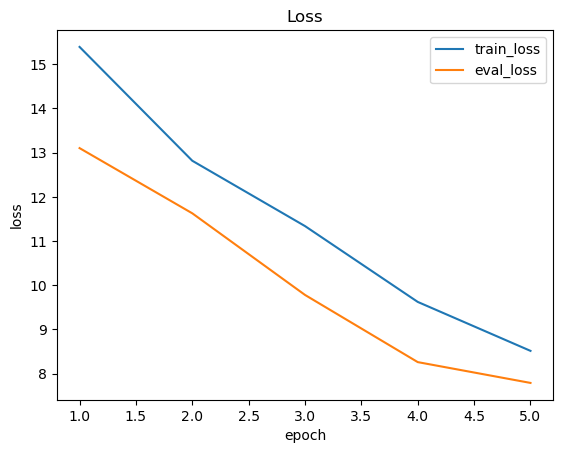

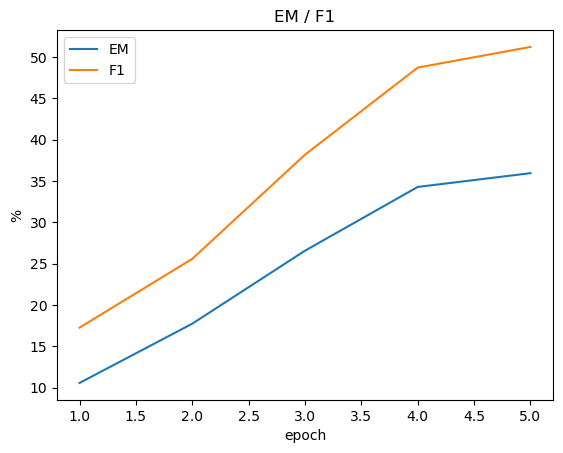

In [32]:
epochs = range(1, len(history_base["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history_base["train_loss"], label="train_loss")
plt.plot(epochs, history_base["eval_loss"], label="eval_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(epochs, history_base["eval_em"], label="EM")
plt.plot(epochs, history_base["eval_f1"], label="F1")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("%")
plt.title("EM / F1")
plt.show()

In [33]:
# LOAD BEST MODEL + TEST
print("\n" + "="*60)
print("LOADING BEST MODEL AND TESTING")
print("="*60)

best_path = OUT_DIR +"/dcn_base/best_dcn_base.pt"
checkpoint = torch.load(best_path, map_location=device)

# Load weights
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Print checkpoint info
epoch = checkpoint.get("epoch", None)
val_f1 = checkpoint.get("val_f1", None)
val_em = checkpoint.get("val_em", None)

if epoch is not None:
    print(f" Loaded best model from epoch {epoch + 1}")
else:
    print(" Loaded best model (epoch unknown)")

if val_f1 is not None:
    print(f"   Val F1: {val_f1:.2f}%")
if val_em is not None:
    print(f"   Val EM: {val_em:.2f}%")

# Evaluate on full validation set
print("\n Evaluating on full validation set...")
loss, final_em, final_f1 = evaluate(model, eval_loader, device)

print(f"\n Final Results:")
print(f" Loss: {loss:.2f}%")
print(f"   EM: {final_em:.2f}%")
print(f"   F1: {final_f1:.2f}%")

# Paper comparison
PAPER_EM = 66.2
PAPER_F1 = 75.9


print(f"\n Paper Results (for comparison):")
print(f"   Single Model EM: {PAPER_EM:.1f}%")
print(f"   Single Model F1: {PAPER_F1:.1f}%")

print(f"\n Your Model vs Paper:")
print(f"   F1 difference: {final_f1 - PAPER_F1:+.2f}%")
print(f"   EM difference: {final_em - PAPER_EM:+.2f}%")


LOADING BEST MODEL AND TESTING
 Loaded best model (epoch unknown)

 Evaluating on full validation set...


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


 Final Results:
 Loss: 7.79%
   EM: 35.95%
   F1: 51.23%

 Paper Results (for comparison):
   Single Model EM: 66.2%
   Single Model F1: 75.9%

 Your Model vs Paper:
   F1 difference: -24.67%
   EM difference: -30.25%


In [34]:
# QUALITATIVE ANALYSIS

def analyze_predictions(model, val_loader, itos, device, num_examples=10, max_ctx_preview=50):
    def decode_tokens(ids_1d, mask_1d):
        # keep only real tokens (mask==True)
        ids = ids_1d[mask_1d].tolist()
        toks = []
        for idx in ids:
            if 0 <= idx < len(itos):
                toks.append(itos[idx])
            else:
                toks.append("<UNK>")
        return toks

    model.eval()

    print("\n" + "="*60)
    print("QUALITATIVE ANALYSIS")
    print("="*60)

    examples_shown = 0
    exact_correct = 0

    for batch in val_loader:

        if random.random() < 0.7:
            continue

        # Move tensors
        context_ids = batch["context_ids"].to(device)
        context_mask = batch["context_mask"].to(device).bool()
        question_ids = batch["question_ids"].to(device)
        question_mask = batch["question_mask"].to(device).bool()
        true_start = batch["start"].cpu().numpy()
        true_end = batch["end"].cpu().numpy()

        # Forward (all iterations)
        with torch.no_grad():
            start_list, end_list = model(
                context_ids, context_mask,
                question_ids, question_mask,
                return_all_iters=True
            )

        # last iteration logits
        start_logits = start_list[-1]
        end_logits = end_list[-1]

        pred_start = torch.argmax(start_logits, dim=1).cpu().numpy()
        pred_end = torch.argmax(end_logits, dim=1).cpu().numpy()

        B = context_ids.size(0)

        for i in range(B):
            if examples_shown >= num_examples:
                break

            ctx_tokens = decode_tokens(context_ids[i].detach().cpu(), context_mask[i].detach().cpu())
            q_tokens   = decode_tokens(question_ids[i].detach().cpu(), question_mask[i].detach().cpu())


            ts, te = int(true_start[i]), int(true_end[i])
            ps, pe = int(pred_start[i]), int(pred_end[i])


            ts = max(0, min(ts, len(ctx_tokens)-1))
            te = max(0, min(te, len(ctx_tokens)-1))
            ps = max(0, min(ps, len(ctx_tokens)-1))
            pe = max(0, min(pe, len(ctx_tokens)-1))


            if te < ts:
                ts, te = te, ts
            if pe < ps:
                ps, pe = pe, ps

            true_answer = " ".join(ctx_tokens[ts:te+1])
            pred_answer = " ".join(ctx_tokens[ps:pe+1])

            is_exact = (ps == ts and pe == te)
            if is_exact:
                exact_correct += 1

            print(f"\n{'='*60}")
            print(f"Example {examples_shown + 1}")
            print(f"{'='*60}")
            print(f"Context (first {max_ctx_preview} toks): {' '.join(ctx_tokens[:max_ctx_preview])}...")
            print(f"\nQuestion: {' '.join(q_tokens)}")
            print(f"\n True answer: {true_answer}")
            print(f"{'✓' if is_exact else '✗'} Predicted:   {pred_answer}")
            print(f"\nPositions: true=[{ts}, {te}], pred=[{ps}, {pe}]")
            print(f"Match: {'EXACT MATCH!' if is_exact else 'INCORRECT'}")

            print(f"Decoder iters used: {len(start_list)}")

            examples_shown += 1

        if examples_shown >= num_examples:
            break

    acc = 100.0 * exact_correct / max(1, examples_shown)
    print(f"\n{'='*60}")
    print(f"Sample exact accuracy: {exact_correct}/{examples_shown} ({acc:.1f}%)")
    print(f"{'='*60}")

# Run analysis
analyze_predictions(model, eval_loader, itos, device, num_examples=10)


QUALITATIVE ANALYSIS

Example 1
Context (first 50 toks): the arthur ravenel jr. bridge across the cooper river opened on july 16 , 2005 , and was the second - longest cable - stayed bridge in the americas at the time of its construction.[citation needed ] the bridge links mount pleasant with downtown charleston , and has eight lanes...

Question: what year did the arthur ravenel jr. bridge open ?

 True answer: 2005
✗ Predicted:   1929

Positions: true=[14, 14], pred=[71, 71]
Match: INCORRECT
Decoder iters used: 2

Example 2
Context (first 50 toks): boston has a continental climate with some maritime influence , and using the <unk> ° c ( 27 ° f ) coldest month ( january ) isotherm , the city lies within the transition zone from a humid subtropical climate ( köppen cfa ) to a humid continental climate (...

Question: what is the hottest month in boston ?

 True answer: july
✓ Predicted:   july

Positions: true=[172, 172], pred=[172, 172]
Match: EXACT MATCH!
Decoder iters used: 2

Examp

In [35]:
# ASK THE MODEL
# context + question -> predicted answer
import torch

def _build_single_batch(context: str, question: str):
    # tokenize
    c_toks, _ = tokenize_with_offsets(context)
    q_toks, _ = tokenize_with_offsets(question)

    # truncate
    c_toks = c_toks[:MAX_C_LEN]
    q_toks = q_toks[:MAX_Q_LEN]

    # numericalize
    c_ids = encode(c_toks, stoi)
    q_ids = encode(q_toks, stoi)

    # pad + mask
    context_ids, context_mask = pad_1d([c_ids])
    question_ids, question_mask = pad_1d([q_ids])


    return (
        context_ids.to(device),
        context_mask.to(device).bool(),
        question_ids.to(device),
        question_mask.to(device).bool(),
        c_toks,
        q_toks
    )

def ask(model, context: str, question: str, return_iters: bool=False):
    model.eval()

    context_ids, context_mask, question_ids, question_mask, c_toks, q_toks = _build_single_batch(context, question)

    with torch.no_grad():
        if return_iters:
            start_list, end_list = model(
                context_ids, context_mask,
                question_ids, question_mask,
                return_all_iters=True
            )
            start_logits = start_list[-1]
            end_logits   = end_list[-1]
        else:
            start_logits, end_logits = model(
                context_ids, context_mask,
                question_ids, question_mask
            )

    ps = int(torch.argmax(start_logits, dim=1).item())
    pe = int(torch.argmax(end_logits, dim=1).item())
    if pe < ps:
        pe = ps

    ps = max(0, min(ps, len(c_toks)-1))
    pe = max(0, min(pe, len(c_toks)-1))

    pred_answer = " ".join(c_toks[ps:pe+1])

    print("Question:", question)
    print("Predicted answer:", pred_answer)
    print("Span:", (ps, pe))

    if return_iters:
        print("Decoder iters used:", len(start_list))
        return pred_answer, (ps, pe), start_list, end_list

    return pred_answer, (ps, pe)


In [36]:
# LONGER CONTEXT + MULTIPLE QUESTIONS

context = """
Dynamic Coattention Networks (DCN) are designed for extractive question answering, meaning the model must
select an answer span directly from a provided context paragraph. The core idea is to compute attention in
both directions: from the question to the context and from the context back to the question, allowing the
model to align relevant parts of the two sequences.

In a typical pipeline, the context and question are tokenized and mapped to integer IDs using a vocabulary.
A boolean mask is built to distinguish real tokens from padding. The model then produces two distributions
over context positions: one for the start index and one for the end index of the answer span.

DCN is often combined with an iterative decoder. At each iteration, the decoder refines its prediction of
the answer span by updating an internal state. When return_all_iters=True, the model returns a list of
start logits and end logits, one pair per iteration, and the final prediction is usually taken from the
last iteration. This iterative refinement can help the model correct earlier mistakes.

However, the model cannot answer questions if the information is not present in the context. In that case,
it may still output a span, but it will likely be incorrect. This behavior is expected because the model
is trained to always select a span.
"""

questions = [
    "What does extractive question answering mean?",
    "What are the two directions of attention described?",
    "What does the model output over context positions?",
    "What is the purpose of the boolean mask?",
    "What happens when return_all_iters=True?",
    "From which iteration is the final prediction usually taken?",
    "Why can iterative refinement help?",
    "What happens if the answer is not present in the context?"
]

for q in questions:
    print("\n" + "="*80)
    ask(model, context, q, return_iters=True)


Question: What does extractive question answering mean?
Predicted answer: 
 dynamic coattention networks
Span: (0, 3)
Decoder iters used: 2

Question: What are the two directions of attention described?
Predicted answer: tokenized
Span: (81, 81)
Decoder iters used: 2

Question: What does the model output over context positions?
Predicted answer: two distributions 

Span: (108, 110)
Decoder iters used: 2

Question: What is the purpose of the boolean mask?
Predicted answer: 
 dynamic coattention networks ( dcn ) are designed for extractive question answering , meaning the model must 
 select an answer span directly from a provided context paragraph . the core idea is to compute attention in 
 both directions : from the question to the context and from the context back to the question , allowing the 
 model to align relevant parts of the two sequences . 

 in a typical pipeline , the context and question are tokenized and mapped to integer ids using a vocabulary . 
 a boolean mask is bui

# 12. Improved DCN: Packed LSTM + Self-Attention

In this section we define a improved DCN with small but effective upgrades:
- Packed LSTM encoding (prevents PAD from polluting hidden states)
- Document self-attention on top of `U` with residual + LayerNorm

In [37]:
class SelfAttentionBlock(nn.Module):
    """
    Lightweight self-attention over the document memory U.
    Residual + LayerNorm
    """
    def __init__(self, d_model: int, num_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor):
        """
        x: [B, T, D]
        key_padding_mask: [B, T] with True on PAD positions
        """
        attn_out, _ = self.mha(x, x, x, key_padding_mask=key_padding_mask, need_weights=False)
        x = self.ln(x + self.drop(attn_out))
        return x

class DCNImproved(DCN):
    """
    Improved DCN:
      1) uses pack/pad in the shared encoder
      2) adds self-attention over U (document memory) with residual + LayerNorm
    """
    def __init__(self, *args, sa_heads: int = 4, sa_dropout: float = 0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.self_attn = SelfAttentionBlock(d_model=2*self.l, num_heads=sa_heads, dropout=sa_dropout)

    def _encode_lstm_packed(self, emb: torch.Tensor, lengths: torch.Tensor):
        """
        emb: [B, T, E]
        lengths: [B] (>=1)
        returns: [B, T, l] (padded)
        """
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out_packed, _ = self.enc(packed)
        out, _ = pad_packed_sequence(out_packed, batch_first=True, total_length=emb.size(1))
        return out

    def _encode_and_coattend(self, context_ids, context_mask, question_ids, question_mask):
        """
        Same as DCN._encode_and_coattend but with:
          - pack/pad for LSTM encodings
          - self-attention over U
        """
        B, m = context_ids.shape
        _, n = question_ids.shape
        l = self.l

        # Embedding + LockedDropout
        D_emb = self.drop(self.emb(context_ids))
        Q_emb = self.drop(self.emb(question_ids))

        # Packed shared encoder
        D_len = context_mask.long().sum(dim=1).clamp(min=1)
        Q_len = question_mask.long().sum(dim=1).clamp(min=1)

        D_enc = self._encode_lstm_packed(D_emb, D_len)
        Q0    = self._encode_lstm_packed(Q_emb, Q_len)
        D_enc = self.drop(D_enc)
        Q0    = self.drop(Q0)

        # Append sentinel
        d_s = self.d_sentinel.view(1, 1, l).expand(B, 1, l)
        q_s = self.q_sentinel.view(1, 1, l).expand(B, 1, l)
        D   = torch.cat([D_enc, d_s], dim=1)
        Q0  = torch.cat([Q0, q_s], dim=1)

        D_mask = torch.cat([context_mask, torch.ones(B, 1, device=context_mask.device, dtype=torch.bool)], dim=1)
        Q_mask = torch.cat([question_mask, torch.ones(B, 1, device=question_mask.device, dtype=torch.bool)], dim=1)

        # Question projection
        Q = torch.tanh(self.q_proj(Q0))

        # Coattention
        L = torch.bmm(D, Q.transpose(1, 2))
        mask_L = D_mask.unsqueeze(2) & Q_mask.unsqueeze(1)

        AQ = masked_softmax(L, mask_L, dim=1)

        LT = L.transpose(1, 2)
        mask_LT = Q_mask.unsqueeze(2) & D_mask.unsqueeze(1)
        AD = masked_softmax(LT, mask_LT, dim=1)

        CQ = torch.bmm(D.transpose(1, 2), AQ).transpose(1, 2)

        QCQ = torch.cat([Q, CQ], dim=2)
        CD  = torch.bmm(AD.transpose(1, 2), QCQ)

        # Fusion BiLSTM
        D_real  = D[:, :m, :]
        CD_real = CD[:, :m, :]
        fuse_in = torch.cat([D_real, CD_real], dim=2)

        U, _ = self.fuse(fuse_in)
        U = self.drop(U)

        # Self-attention over U
        key_padding_mask = ~context_mask
        U = self.self_attn(U, key_padding_mask=key_padding_mask)

        return U

In [38]:
# Train
print(OUT_DIR)
EPOCH = 5

improved_model = DCNImproved(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=0.2,
        max_decoder_iters=4,
        freeze_emb=True,
        sa_heads=4,
        sa_dropout=0.10
    ).to(device)

history_i, ckpt_path_i, best_eval_i = train_dcn(
        model=improved_model,
        train_loader=train_loader,
        eval_loader=eval_loader,
        device=device,
        out_dir=OUT_DIR + "/dcn_improved",
        stoi=stoi,
        itos=itos,
        emb_dim=EMB_DIM,
        max_c_len=MAX_C_LEN,
        max_q_len=MAX_Q_LEN,
        seed=42,
        epochs=EPOCH,
        lr=0.001,
        clip=CLIP,
        early_stop=True,
        patience=2,
        skip_training=False,
        best_filename=f"best_improved_dcn.pt"
    )

outputs/finals


Train epoch 1:  63%|██████▎   | 500/795 [04:39<02:33,  1.92it/s, loss=18.8239]

  step 500: avg_loss=18.8239


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]



Epoch 1/5 | train_loss=17.7089 | eval_loss=14.1982 | EM=10.81% | F1=16.45%
Saved best model to: outputs/finals/dcn_improved/best_improved_dcn.pt (eval_loss=14.1982)


Train epoch 2:  63%|██████▎   | 500/795 [04:31<02:42,  1.82it/s, loss=14.9000]

  step 500: avg_loss=14.9000


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 2/5 | train_loss=14.3984 | eval_loss=12.9730 | EM=15.71% | F1=22.64%
Saved best model to: outputs/finals/dcn_improved/best_improved_dcn.pt (eval_loss=12.9730)


Train epoch 3:  63%|██████▎   | 500/795 [04:25<02:36,  1.89it/s, loss=12.9764]

  step 500: avg_loss=12.9764


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 3/5 | train_loss=12.6651 | eval_loss=12.6635 | EM=21.90% | F1=31.90%
Saved best model to: outputs/finals/dcn_improved/best_improved_dcn.pt (eval_loss=12.6635)


Train epoch 4:  63%|██████▎   | 500/795 [04:26<02:28,  1.99it/s, loss=10.9388]

  step 500: avg_loss=10.9388


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.63it/s]



Epoch 4/5 | train_loss=10.5839 | eval_loss=8.6343 | EM=32.37% | F1=46.62%
Saved best model to: outputs/finals/dcn_improved/best_improved_dcn.pt (eval_loss=8.6343)


Train epoch 5:  63%|██████▎   | 500/795 [04:24<02:43,  1.80it/s, loss=9.0374]

  step 500: avg_loss=9.0374


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch 5/5 | train_loss=8.9486 | eval_loss=7.9591 | EM=35.81% | F1=51.62%
Saved best model to: outputs/finals/dcn_improved/best_improved_dcn.pt (eval_loss=7.9591)


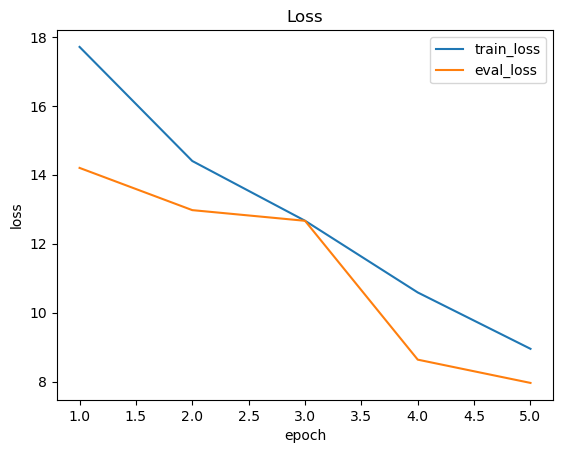

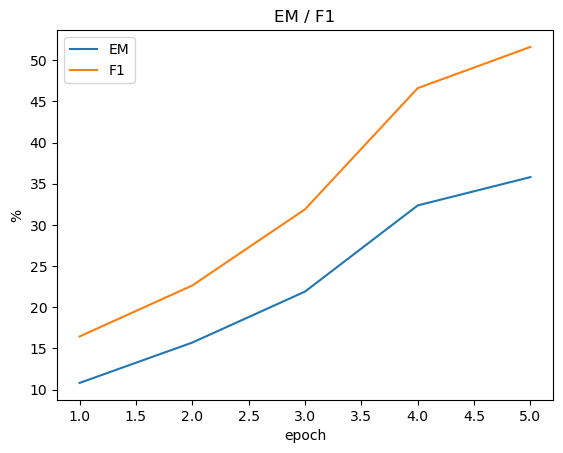

In [39]:
epochs = range(1, len(history_i["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history_i["train_loss"], label="train_loss")
plt.plot(epochs, history_i["eval_loss"], label="eval_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(epochs, history_i["eval_em"], label="EM")
plt.plot(epochs, history_i["eval_f1"], label="F1")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("%")
plt.title("EM / F1")
plt.show()


In [40]:
# LOAD BEST MODEL + TEST
print("\n" + "="*60)
print("LOADING BEST MODEL AND TESTING")
print("="*60)

best_path = OUT_DIR + "/dcn_improved/best_improved_dcn.pt"

checkpoint = torch.load(best_path, map_location=device)

# Load weights
improved_model.load_state_dict(checkpoint["model_state_dict"])
improved_model.to(device)

# Print checkpoint info
epoch = checkpoint.get("epoch", None)
val_f1 = checkpoint.get("val_f1", None)
val_em = checkpoint.get("val_em", None)

if epoch is not None:
    print(f" Loaded best model from epoch {epoch + 1}")
else:
    print(" Loaded best model (epoch unknown)")

if val_f1 is not None:
    print(f"   Val F1: {val_f1:.2f}%")
if val_em is not None:
    print(f"   Val EM: {val_em:.2f}%")

# Evaluate on full validation set
print("\n Evaluating on full validation set...")
loss, final_em, final_f1 = evaluate(improved_model, eval_loader, device)

print(f"\n Final Results:")
print(f" Loss: {loss:.2f}%")
print(f"   EM: {final_em:.2f}%")
print(f"   F1: {final_f1:.2f}%")

# Paper comparison
PAPER_EM = 66.2
PAPER_F1 = 75.9


print(f"\n Paper Results (for comparison):")
print(f"   Single Model EM: {PAPER_EM:.1f}%")
print(f"   Single Model F1: {PAPER_F1:.1f}%")

print(f"\n Your Model vs Paper:")
print(f"   F1 difference: {final_f1 - PAPER_F1:+.2f}%")
print(f"   EM difference: {final_em - PAPER_EM:+.2f}%")


LOADING BEST MODEL AND TESTING
 Loaded best model (epoch unknown)

 Evaluating on full validation set...


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


 Final Results:
 Loss: 7.96%
   EM: 35.81%
   F1: 51.62%

 Paper Results (for comparison):
   Single Model EM: 66.2%
   Single Model F1: 75.9%

 Your Model vs Paper:
   F1 difference: -24.28%
   EM difference: -30.39%


In [41]:
# QUALITATIVE ANALYSIS

def analyze_predictions(model, val_loader, itos, device, num_examples=10, max_ctx_preview=50):
    def decode_tokens(ids_1d, mask_1d):
        ids = ids_1d[mask_1d].tolist()
        toks = []
        for idx in ids:
            if 0 <= idx < len(itos):
                toks.append(itos[idx])
            else:
                toks.append("<UNK>")
        return toks

    model.eval()

    print("\n" + "="*60)
    print("QUALITATIVE ANALYSIS")
    print("="*60)

    examples_shown = 0
    exact_correct = 0

    for batch in val_loader:

        if random.random() < 0.7:
            continue

        # Move tensors
        context_ids = batch["context_ids"].to(device)
        context_mask = batch["context_mask"].to(device).bool()
        question_ids = batch["question_ids"].to(device)
        question_mask = batch["question_mask"].to(device).bool()
        true_start = batch["start"].cpu().numpy()
        true_end = batch["end"].cpu().numpy()

        # Forward (all iterations)
        with torch.no_grad():
            start_list, end_list = model(
                context_ids, context_mask,
                question_ids, question_mask,
                return_all_iters=True
            )

        # last iteration logits
        start_logits = start_list[-1]
        end_logits = end_list[-1]

        pred_start = torch.argmax(start_logits, dim=1).cpu().numpy()
        pred_end = torch.argmax(end_logits, dim=1).cpu().numpy()

        B = context_ids.size(0)

        for i in range(B):
            if examples_shown >= num_examples:
                break

            # Decode tokens
            ctx_tokens = decode_tokens(context_ids[i].detach().cpu(), context_mask[i].detach().cpu())
            q_tokens   = decode_tokens(question_ids[i].detach().cpu(), question_mask[i].detach().cpu())

            # Safety clamp
            ts, te = int(true_start[i]), int(true_end[i])
            ps, pe = int(pred_start[i]), int(pred_end[i])

            # Ensure indices within range of ctx_tokens
            ts = max(0, min(ts, len(ctx_tokens)-1))
            te = max(0, min(te, len(ctx_tokens)-1))
            ps = max(0, min(ps, len(ctx_tokens)-1))
            pe = max(0, min(pe, len(ctx_tokens)-1))

            if te < ts:
                ts, te = te, ts
            if pe < ps:
                ps, pe = pe, ps

            true_answer = " ".join(ctx_tokens[ts:te+1])
            pred_answer = " ".join(ctx_tokens[ps:pe+1])

            is_exact = (ps == ts and pe == te)
            if is_exact:
                exact_correct += 1

            print(f"\n{'='*60}")
            print(f"Example {examples_shown + 1}")
            print(f"{'='*60}")
            print(f"Context (first {max_ctx_preview} toks): {' '.join(ctx_tokens[:max_ctx_preview])}...")
            print(f"\nQuestion: {' '.join(q_tokens)}")
            print(f"\n True answer: {true_answer}")
            print(f"{'✓' if is_exact else '✗'} Predicted:   {pred_answer}")
            print(f"\nPositions: true=[{ts}, {te}], pred=[{ps}, {pe}]")
            print(f"Match: {'EXACT MATCH!' if is_exact else 'INCORRECT'}")

            print(f"Decoder iters used: {len(start_list)}")

            examples_shown += 1

        if examples_shown >= num_examples:
            break

    acc = 100.0 * exact_correct / max(1, examples_shown)
    print(f"\n{'='*60}")
    print(f"Sample exact accuracy: {exact_correct}/{examples_shown} ({acc:.1f}%)")
    print(f"{'='*60}")

# Run analysis
analyze_predictions(improved_model, eval_loader, itos, device, num_examples=10)


QUALITATIVE ANALYSIS

Example 1
Context (first 50 toks): white - box testing ( also known as clear box testing , glass box testing , transparent box testing and structural testing , by seeing the source code ) tests internal structures or workings of a program , as opposed to the functionality exposed to the end - user ....

Question: what is involved with white - box testing ?

 True answer: by seeing the source code
✗ Predicted:   clear box testing

Positions: true=[23, 27], pred=[8, 10]
Match: INCORRECT
Decoder iters used: 2

Example 2
Context (first 50 toks): between 10 and 17 october 1757 , a hungarian general , count andrás hadik , serving in the austrian army , executed what may be the most famous hussar action in history . when the prussian king frederick was marching south with his powerful armies , the hungarian general unexpectedly...

Question: what city did hadik occupy ?

 True answer: occupied part of their capital , berlin , for one night
✗ Predicted:   berlin

Positio

In [42]:
# LONGER CONTEXT + MULTIPLE QUESTIONS

context = """
Dynamic Coattention Networks (DCN) are designed for extractive question answering, meaning the model must
select an answer span directly from a provided context paragraph. The core idea is to compute attention in
both directions: from the question to the context and from the context back to the question, allowing the
model to align relevant parts of the two sequences.

In a typical pipeline, the context and question are tokenized and mapped to integer IDs using a vocabulary.
A boolean mask is built to distinguish real tokens from padding. The model then produces two distributions
over context positions: one for the start index and one for the end index of the answer span.

DCN is often combined with an iterative decoder. At each iteration, the decoder refines its prediction of
the answer span by updating an internal state. When return_all_iters=True, the model returns a list of
start logits and end logits, one pair per iteration, and the final prediction is usually taken from the
last iteration. This iterative refinement can help the model correct earlier mistakes.

However, the model cannot answer questions if the information is not present in the context. In that case,
it may still output a span, but it will likely be incorrect. This behavior is expected because the model
is trained to always select a span.
"""

questions = [
    "What does extractive question answering mean?",
    "What are the two directions of attention described?",
    "What does the model output over context positions?",
    "What is the purpose of the boolean mask?",
    "What happens when return_all_iters=True?",
    "From which iteration is the final prediction usually taken?",
    "Why can iterative refinement help?",
    "What happens if the answer is not present in the context?"
]

for q in questions:
    print("\n" + "="*80)
    ask(improved_model, context, q, return_iters=True)


Question: What does extractive question answering mean?
Predicted answer: the model must 
 select an answer span directly from a provided context paragraph
Span: (15, 28)
Decoder iters used: 2

Question: What are the two directions of attention described?
Predicted answer: align relevant parts of the two sequences
Span: (62, 68)
Decoder iters used: 2

Question: What does the model output over context positions?
Predicted answer: two distributions 

Span: (108, 110)
Decoder iters used: 2

Question: What is the purpose of the boolean mask?
Predicted answer: padding
Span: (102, 102)
Decoder iters used: 2

Question: What happens when return_all_iters=True?
Predicted answer: the model returns a list of 
 start logits and end logits , one pair per iteration , and the final prediction is usually taken from the 
 last iteration
Span: (166, 195)
Decoder iters used: 2

Question: From which iteration is the final prediction usually taken?
Predicted answer: 
 last iteration
Span: (193, 195)
Decod

# 13. Ensemble

In [43]:
class EnsembleDCN(nn.Module):
    """
    Ensemble model that combines predictions from multiple DCN models
    """

    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.num_models = len(models)

        print(f"\n{'='*60}")
        print(f"ENSEMBLE MODEL CREATED")
        print(f"{'='*60}")
        print(f"  Number of models: {self.num_models}")
        print(f"  Model types: {[type(m).__name__ for m in models]}")
        print(f"{'='*60}\n")

    def forward(self, context_ids, context_mask, question_ids, question_mask, return_all_iters: bool = False):
        def unwrap_last(x):
            # x may be tensor, list, nested list
            if isinstance(x, (list, tuple)):
                x = x[-1]
            if isinstance(x, (list, tuple)):
                x = x[0]
            if isinstance(x, (list, tuple)):
                x = x[-1]
            if torch.is_tensor(x) and x.dim() == 1:
                x = x.unsqueeze(0)
            return x

        start_probs_sum = None
        end_probs_sum = None

        all_start_logits = []
        all_end_logits = []

        for model in self.models:
            out = model(context_ids, context_mask, question_ids, question_mask, return_all_iters=True)

            start_logits_seq, end_logits_seq = out
            start_logits_seq = [unwrap_last(s) for s in start_logits_seq]
            end_logits_seq   = [unwrap_last(e) for e in end_logits_seq]

            # Convert to probs for averaging
            start_probs_seq = [F.softmax(s, dim=1) for s in start_logits_seq]
            end_probs_seq   = [F.softmax(e, dim=1) for e in end_logits_seq]

            if start_probs_sum is None:
                start_probs_sum = start_probs_seq[-1].clone()
                end_probs_sum   = end_probs_seq[-1].clone()
            else:
                start_probs_sum += start_probs_seq[-1]
                end_probs_sum   += end_probs_seq[-1]


            if return_all_iters:
                while len(all_start_logits) < len(start_probs_seq):
                    all_start_logits.append(0.0)
                    all_end_logits.append(0.0)
                for i in range(len(start_probs_seq)):
                    all_start_logits[i] = all_start_logits[i] + start_probs_seq[i]
                    all_end_logits[i]   = all_end_logits[i]   + end_probs_seq[i]

        # Average final probabilities
        start_probs = start_probs_sum / self.num_models
        end_probs   = end_probs_sum / self.num_models

        # Convert back to logits (log-prob)
        start_logits = torch.log(start_probs + 1e-30)
        end_logits   = torch.log(end_probs + 1e-30)

        if not return_all_iters:
            return start_logits, end_logits

        # Average per-iter
        start_logits_list = [torch.log((p / self.num_models) + 1e-30) for p in all_start_logits]
        end_logits_list   = [torch.log((p / self.num_models) + 1e-30) for p in all_end_logits]
        return start_logits_list, end_logits_list


In [44]:
@torch.no_grad()
def evaluate_ensemble(ensemble_model, data_loader, device):
    ensemble_model.eval()

    total_em = 0
    total_f1 = 0.0
    total_examples = 0

    for batch in tqdm(data_loader, desc="Ensemble Evaluation"):
        start_out, end_out = ensemble_model(
            batch["context_ids"].to(device),
            batch["context_mask"].to(device),
            batch["question_ids"].to(device),
            batch["question_mask"].to(device),
        )

        def unwrap_last(x):
            if isinstance(x, (list, tuple)):
                x = x[-1]
            if isinstance(x, (list, tuple)):
                x = x[0]
            return x

        start_scores = unwrap_last(start_out)
        end_scores   = unwrap_last(end_out)

        pred_start = torch.argmax(start_scores, dim=1).cpu()
        pred_end   = torch.argmax(end_scores, dim=1).cpu()

        true_start = batch["start"].cpu()
        true_end   = batch["end"].cpu()

        bs = pred_start.size(0)

        for i in range(bs):
            ps, pe = int(pred_start[i]), int(pred_end[i])
            ts, te = int(true_start[i]), int(true_end[i])

            if pe < ps:
                ps, pe = pe, ps

            # EM
            if ps == ts and pe == te:
                total_em += 1

            # F1
            pred_span = set(range(ps, pe + 1))
            true_span = set(range(ts, te + 1))

            overlap = len(pred_span & true_span)
            precision = overlap / max(1, len(pred_span))
            recall = overlap / max(1, len(true_span))
            f1 = 0.0 if (precision + recall) == 0 else (2 * precision * recall / (precision + recall))

            total_f1 += f1
            total_examples += 1

    avg_em = 100.0 * total_em / max(1, total_examples)
    avg_f1 = 100.0 * total_f1 / max(1, total_examples)
    return avg_em, avg_f1


In [47]:
# TRAIN ENSEMBLE FUNCTION

def train_ensemble(ensemble_model, train_loader, val_loader, device,
                  num_epochs=5, learning_rate=0.00001, patience=3):
    print("\n" + "="*60)
    print("TRAINING ENSEMBLE MODEL (FINE-TUNING)")
    print("="*60)
    print("Note: Ensemble training is optional. The paper uses simple averaging.")
    print("="*60 + "\n")

    ensemble_model = ensemble_model.to(device)

    # Optimizer with very small learning rate
    optimizer = optim.Adam(ensemble_model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [],
        'val_em': [],
        'val_f1': []
    }

    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 60)

        ensemble_model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, batch in enumerate(progress_bar):
            context = batch['context'].to(device)
            question = batch['question'].to(device)
            answer_start = batch['answer_start'].to(device)
            answer_end = batch['answer_end'].to(device)

            # Forward pass
            start_scores_list, end_scores_list = ensemble_model(
                context, question,
                batch['context_lengths'],
                batch['question_lengths']
            )

            start_scores = start_scores_list[-1][0]
            end_scores = end_scores_list[-1][0]

            # Compute loss
            loss = criterion(start_scores, answer_start) + criterion(end_scores, answer_end)
            loss = loss / 2

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ensemble_model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)

        # Evaluate
        print("Validating...")
        val_em, val_f1 = evaluate_ensemble(ensemble_model, val_loader, device)

        history['train_loss'].append(avg_train_loss)
        history['val_em'].append(val_em)
        history['val_f1'].append(val_f1)

        print(f"\nResults:")
        print(f"  Train loss: {avg_train_loss:.4f}")
        print(f"  Val EM: {val_em:.2f}%")
        print(f"  Val F1: {val_f1:.2f}%")

        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': ensemble_model.state_dict(),
                'val_f1': val_f1,
                'val_em': val_em
            }, 'best_ensemble.pt')

            print(f"  ✓ New best ensemble model saved!")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping after {epoch + 1} epochs")
            break

    return history

In [49]:
# TRAIN MULTIPLE MODELS FOR ENSEMBLE (4 models each type)
NUM_EPOCH = 5

print("\n" + "="*60)
print("TRAINING ENSEMBLE MODELS")
print("="*60)
print("This will train:")
print("  • 3 Original DCN models (different random seeds)")
print("  • 3 Improved DCN models (different random seeds)")
print("="*60)

original_histories = []
improved_histories = []

# Configuration for ensemble diversity
original_configs = [
    {'seed': 42,  'dropout': 0.20, 'lr': 0.005},
    {'seed': 123, 'dropout': 0.25, 'lr': 1e-3},
    {'seed': 456, 'dropout': 0.20, 'lr': 1e-3},
]

improved_configs = [
    {'seed': 42,  'dropout': 0.20, 'lr': 1e-3},
    {'seed': 123, 'dropout': 0.22, 'lr': 1e-3},
    {'seed': 456, 'dropout': 0.28, 'lr': 1e-3},
]

OUT_DIR = OUT_DIR + "/ensemble"
os.makedirs(OUT_DIR, exist_ok=True)

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# TRAIN 4 ORIGINAL DCN MODELS
print("\n" + "="*60)
print("TRAINING ORIGINAL DCN ENSEMBLE (3 MODELS)")
print("="*60)

original_ensemble_models = []

for i, config in enumerate(original_configs):
    print(f"\n{'='*60}")
    print(f"Training Original DCN Model {i+1}/3")
    print(f"{'='*60}")
    print(f"Config: seed={config['seed']}, dropout={config['dropout']}, lr={config['lr']}")

    set_seed(config['seed'])

    original_model_i = DCN(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=config['dropout'],
        max_decoder_iters=4,
        freeze_emb=True
    ).to(device)

    history_i, ckpt_path_i, best_eval_i = train_dcn(
        model=original_model_i,
        train_loader=train_loader,
        eval_loader=eval_loader,
        device=device,
        out_dir=OUT_DIR,
        stoi=stoi,
        itos=itos,
        emb_dim=EMB_DIM,
        max_c_len=MAX_C_LEN,
        max_q_len=MAX_Q_LEN,
        seed=config["seed"],
        epochs=NUM_EPOCH,
        lr=config["lr"],
        clip=CLIP,
        early_stop=True,
        patience=2,
        skip_training=False,
        best_filename=f"best_original_dcn_{i}.pt"
    )

    # store history for mean plots
    original_histories.append(history_i)

    checkpoint_i = torch.load(ckpt_path_i, map_location=device)
    original_model_i.load_state_dict(checkpoint_i["model_state_dict"])
    original_model_i.eval()

    _, val_em_i, val_f1_i = evaluate(original_model_i, eval_loader, device=device)
    print(f"✓ Original Model {i+1} - Val EM: {val_em_i:.2f}% | Val F1: {val_f1_i:.2f}%")

    original_ensemble_models.append(original_model_i)

    torch.save({
        "model_state_dict": original_model_i.state_dict(),
        "val_f1": val_f1_i,
        "val_em": val_em_i,
        "config": config,
        "type": "original",
        "selected_by": "eval_loss",
        "best_eval_loss": checkpoint_i.get("eval_loss", None),
    }, os.path.join(OUT_DIR, f"original_dcn_model_{i+1}.pt"))

# TRAIN 4 IMPROVED DCN MODELS
print("\n" + "="*60)
print("TRAINING IMPROVED DCN ENSEMBLE (3 MODELS)")
print("="*60)

improved_ensemble_models = []

for i, config in enumerate(improved_configs):
    print(f"\n{'='*60}")
    print(f"Training Improved DCN Model {i+1}/3")
    print(f"{'='*60}")
    print(f"Config: seed={config['seed']}, dropout={config['dropout']}, lr={config['lr']}")

    set_seed(config['seed'])

    improved_model_i = DCNImproved(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=config['dropout'],
        max_decoder_iters=4,
        freeze_emb=True,
        sa_heads=4,
        sa_dropout=0.10
    ).to(device)

    history_i, ckpt_path_i, best_eval_i = train_dcn(
        model=improved_model_i,
        train_loader=train_loader,
        eval_loader=eval_loader,
        device=device,
        out_dir=OUT_DIR,
        stoi=stoi,
        itos=itos,
        emb_dim=EMB_DIM,
        max_c_len=MAX_C_LEN,
        max_q_len=MAX_Q_LEN,
        seed=config["seed"],
        epochs=NUM_EPOCH,
        lr=config["lr"],
        clip=CLIP,
        early_stop=True,
        patience=2,
        skip_training=False,
        best_filename=f"best_improved_dcn_{i}.pt"
    )

    improved_histories.append(history_i)

    checkpoint_i = torch.load(ckpt_path_i, map_location=device)
    improved_model_i.load_state_dict(checkpoint_i["model_state_dict"])
    improved_model_i.eval()

    _, val_em_i, val_f1_i = evaluate(improved_model_i, eval_loader, device=device)
    print(f"✓ Improved Model {i+1} - Val EM: {val_em_i:.2f}% | Val F1: {val_f1_i:.2f}%")

    improved_ensemble_models.append(improved_model_i)

    torch.save({
        "model_state_dict": improved_model_i.state_dict(),
        "val_f1": val_f1_i,
        "val_em": val_em_i,
        "config": config,
        "type": "improved",
        "selected_by": "eval_loss",
        "best_eval_loss": checkpoint_i.get("eval_loss", None),
    }, os.path.join(OUT_DIR, f"improved_dcn_model_{i+1}.pt"))


# CREATE ENSEMBLES (Original, Improved, Mixed)
print("\n" + "="*60)
print("CREATING ENSEMBLE MODELS")
print("="*60)

ensemble_original = EnsembleDCN(original_ensemble_models)
print(f"✓ Ensemble Original created with {len(original_ensemble_models)} models")

ensemble_improved = EnsembleDCN(improved_ensemble_models)
print(f"✓ Ensemble Improved created with {len(improved_ensemble_models)} models")

# Mixed ensemble: include BOTH model families (this is what you asked)
ensemble_mixed = EnsembleDCN(original_ensemble_models + improved_ensemble_models)
print(f"✓ Ensemble Mixed created with {len(original_ensemble_models) + len(improved_ensemble_models)} models")

print("\n" + "="*60)
print("ENSEMBLE MODELS READY")
print("="*60)
print(f"  • Ensemble Original: {len(original_ensemble_models)} models")
print(f"  • Ensemble Improved: {len(improved_ensemble_models)} models")
print(f"  • Ensemble Mixed:    {len(original_ensemble_models) + len(improved_ensemble_models)} models")
print("="*60)



TRAINING ENSEMBLE MODELS
This will train:
  • 3 Original DCN models (different random seeds)
  • 3 Improved DCN models (different random seeds)

TRAINING ORIGINAL DCN ENSEMBLE (3 MODELS)

Training Original DCN Model 1/3
Config: seed=42, dropout=0.2, lr=0.005


Train epoch 1:  63%|██████▎   | 500/795 [04:09<02:21,  2.08it/s, loss=16.0715]

  step 500: avg_loss=16.0715


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 1/5 | train_loss=15.3516 | eval_loss=13.5968 | EM=9.75% | F1=16.10%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_0.pt (eval_loss=13.5968)


Train epoch 2:  63%|██████▎   | 500/795 [04:08<02:25,  2.03it/s, loss=13.3815]

  step 500: avg_loss=13.3815


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.72it/s]



Epoch 2/5 | train_loss=13.3502 | eval_loss=12.5568 | EM=13.04% | F1=19.99%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_0.pt (eval_loss=12.5568)


Train epoch 3:  63%|██████▎   | 500/795 [04:06<02:26,  2.01it/s, loss=12.7600]

  step 500: avg_loss=12.7600


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.66it/s]



Epoch 3/5 | train_loss=12.7231 | eval_loss=12.1176 | EM=15.14% | F1=22.09%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_0.pt (eval_loss=12.1176)


Train epoch 4:  63%|██████▎   | 500/795 [04:06<02:38,  1.86it/s, loss=12.3842]

  step 500: avg_loss=12.3842


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]



Epoch 4/5 | train_loss=12.2870 | eval_loss=11.8382 | EM=15.88% | F1=23.30%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_0.pt (eval_loss=11.8382)


Train epoch 5:  63%|██████▎   | 500/795 [04:06<02:26,  2.01it/s, loss=11.9228]

  step 500: avg_loss=11.9228


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]



Epoch 5/5 | train_loss=11.9100 | eval_loss=11.6696 | EM=17.23% | F1=24.36%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_0.pt (eval_loss=11.6696)


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]


✓ Original Model 1 - Val EM: 17.23% | Val F1: 24.36%

Training Original DCN Model 2/3
Config: seed=123, dropout=0.25, lr=0.001


Train epoch 1:  63%|██████▎   | 500/795 [04:11<02:22,  2.07it/s, loss=16.8220]

  step 500: avg_loss=16.8220


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]



Epoch 1/5 | train_loss=15.9774 | eval_loss=13.4394 | EM=10.21% | F1=16.42%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_1.pt (eval_loss=13.4394)


Train epoch 2:  63%|██████▎   | 500/795 [04:10<02:30,  1.96it/s, loss=13.6075]

  step 500: avg_loss=13.6075


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 2/5 | train_loss=13.4348 | eval_loss=12.3113 | EM=14.59% | F1=21.63%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_1.pt (eval_loss=12.3113)


Train epoch 3:  63%|██████▎   | 500/795 [04:07<02:32,  1.94it/s, loss=12.5454]

  step 500: avg_loss=12.5454


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]



Epoch 3/5 | train_loss=12.5134 | eval_loss=11.8101 | EM=16.26% | F1=24.19%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_1.pt (eval_loss=11.8101)


Train epoch 4:  63%|██████▎   | 500/795 [04:07<02:20,  2.10it/s, loss=12.1553]

  step 500: avg_loss=12.1553


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.66it/s]



Epoch 4/5 | train_loss=12.0389 | eval_loss=11.6693 | EM=19.35% | F1=27.89%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_1.pt (eval_loss=11.6693)


Train epoch 5:  63%|██████▎   | 500/795 [04:11<02:31,  1.95it/s, loss=11.6571]

  step 500: avg_loss=11.6571


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 5/5 | train_loss=11.5469 | eval_loss=11.0255 | EM=21.56% | F1=30.97%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_1.pt (eval_loss=11.0255)


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]


✓ Original Model 2 - Val EM: 21.56% | Val F1: 30.97%

Training Original DCN Model 3/3
Config: seed=456, dropout=0.2, lr=0.001


Train epoch 1:  63%|██████▎   | 500/795 [04:07<02:15,  2.18it/s, loss=15.9417]

  step 500: avg_loss=15.9417


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]



Epoch 1/5 | train_loss=15.1197 | eval_loss=12.9655 | EM=11.87% | F1=18.54%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_2.pt (eval_loss=12.9655)


Train epoch 2:  63%|██████▎   | 500/795 [04:04<02:25,  2.03it/s, loss=12.7443]

  step 500: avg_loss=12.7443


Evaluating: 100%|██████████| 109/109 [00:42<00:00,  2.58it/s]



Epoch 2/5 | train_loss=12.4498 | eval_loss=10.7955 | EM=21.93% | F1=32.10%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_2.pt (eval_loss=10.7955)


Train epoch 3:  63%|██████▎   | 500/795 [04:11<02:28,  1.99it/s, loss=10.7029]

  step 500: avg_loss=10.7029


Evaluating: 100%|██████████| 109/109 [00:42<00:00,  2.55it/s]



Epoch 3/5 | train_loss=10.4148 | eval_loss=8.7509 | EM=32.74% | F1=47.18%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_2.pt (eval_loss=8.7509)


Train epoch 4:  63%|██████▎   | 500/795 [04:09<02:29,  1.98it/s, loss=9.0806]

  step 500: avg_loss=9.0806


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.71it/s]



Epoch 4/5 | train_loss=8.9896 | eval_loss=7.9847 | EM=35.84% | F1=51.30%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_2.pt (eval_loss=7.9847)


Train epoch 5:  63%|██████▎   | 500/795 [04:08<02:26,  2.01it/s, loss=8.1943]

  step 500: avg_loss=8.1943


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.70it/s]



Epoch 5/5 | train_loss=8.1701 | eval_loss=7.7193 | EM=37.39% | F1=53.39%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_original_dcn_2.pt (eval_loss=7.7193)


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]


✓ Original Model 3 - Val EM: 37.39% | Val F1: 53.39%

TRAINING IMPROVED DCN ENSEMBLE (3 MODELS)

Training Improved DCN Model 1/3
Config: seed=42, dropout=0.2, lr=0.001


Train epoch 1:  63%|██████▎   | 500/795 [04:32<02:37,  1.87it/s, loss=17.7658]

  step 500: avg_loss=17.7658


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]



Epoch 1/5 | train_loss=16.7059 | eval_loss=13.7701 | EM=9.58% | F1=15.64%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_0.pt (eval_loss=13.7701)


Train epoch 2:  63%|██████▎   | 500/795 [04:31<02:41,  1.83it/s, loss=14.6747]

  step 500: avg_loss=14.6747


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 2/5 | train_loss=14.2510 | eval_loss=12.5775 | EM=13.65% | F1=21.04%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_0.pt (eval_loss=12.5775)


Train epoch 3:  63%|██████▎   | 500/795 [04:25<02:36,  1.88it/s, loss=12.7378]

  step 500: avg_loss=12.7378


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.66it/s]



Epoch 3/5 | train_loss=12.6244 | eval_loss=11.8573 | EM=17.32% | F1=25.77%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_0.pt (eval_loss=11.8573)


Train epoch 4:  63%|██████▎   | 500/795 [04:22<02:26,  2.01it/s, loss=11.7369]

  step 500: avg_loss=11.7369


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 4/5 | train_loss=11.6837 | eval_loss=10.6370 | EM=22.02% | F1=31.95%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_0.pt (eval_loss=10.6370)


Train epoch 5:  63%|██████▎   | 500/795 [04:22<02:25,  2.02it/s, loss=10.4727]

  step 500: avg_loss=10.4727


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]



Epoch 5/5 | train_loss=10.2653 | eval_loss=8.8811 | EM=30.53% | F1=43.40%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_0.pt (eval_loss=8.8811)


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


✓ Improved Model 1 - Val EM: 30.53% | Val F1: 43.40%

Training Improved DCN Model 2/3
Config: seed=123, dropout=0.22, lr=0.001


Train epoch 1:  63%|██████▎   | 500/795 [04:34<02:38,  1.87it/s, loss=18.1140]

  step 500: avg_loss=18.1140


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 1/5 | train_loss=16.8833 | eval_loss=13.5286 | EM=10.89% | F1=17.22%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_1.pt (eval_loss=13.5286)


Train epoch 2:  63%|██████▎   | 500/795 [04:24<02:32,  1.94it/s, loss=13.6086]

  step 500: avg_loss=13.6086


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]



Epoch 2/5 | train_loss=13.3305 | eval_loss=11.7549 | EM=18.55% | F1=26.70%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_1.pt (eval_loss=11.7549)


Train epoch 3:  63%|██████▎   | 500/795 [04:23<02:33,  1.92it/s, loss=11.8856]

  step 500: avg_loss=11.8856


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.62it/s]



Epoch 3/5 | train_loss=11.4695 | eval_loss=9.5039 | EM=27.95% | F1=42.08%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_1.pt (eval_loss=9.5039)


Train epoch 4:  63%|██████▎   | 500/795 [04:24<02:33,  1.92it/s, loss=9.8599] 

  step 500: avg_loss=9.8599


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]



Epoch 4/5 | train_loss=9.7235 | eval_loss=8.3047 | EM=34.46% | F1=49.66%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_1.pt (eval_loss=8.3047)


Train epoch 5:  63%|██████▎   | 500/795 [04:22<02:34,  1.91it/s, loss=8.7751]

  step 500: avg_loss=8.7751


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 5/5 | train_loss=8.7327 | eval_loss=7.6705 | EM=37.53% | F1=53.86%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_1.pt (eval_loss=7.6705)


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


✓ Improved Model 2 - Val EM: 37.53% | Val F1: 53.86%

Training Improved DCN Model 3/3
Config: seed=456, dropout=0.28, lr=0.001


Train epoch 1:  63%|██████▎   | 500/795 [04:35<02:42,  1.82it/s, loss=19.0435]

  step 500: avg_loss=19.0435


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]



Epoch 1/5 | train_loss=17.5923 | eval_loss=14.1456 | EM=9.23% | F1=15.43%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_2.pt (eval_loss=14.1456)


Train epoch 2:  63%|██████▎   | 500/795 [04:23<02:31,  1.95it/s, loss=13.9713]

  step 500: avg_loss=13.9713


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]



Epoch 2/5 | train_loss=13.6514 | eval_loss=12.1232 | EM=14.79% | F1=22.69%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_2.pt (eval_loss=12.1232)


Train epoch 3:  63%|██████▎   | 500/795 [04:24<02:34,  1.91it/s, loss=12.5747]

  step 500: avg_loss=12.5747


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 3/5 | train_loss=12.2986 | eval_loss=10.3825 | EM=24.68% | F1=35.34%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_2.pt (eval_loss=10.3825)


Train epoch 4:  63%|██████▎   | 500/795 [04:23<02:31,  1.94it/s, loss=10.9324]

  step 500: avg_loss=10.9324


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.62it/s]



Epoch 4/5 | train_loss=10.7652 | eval_loss=9.0252 | EM=29.64% | F1=43.34%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_2.pt (eval_loss=9.0252)


Train epoch 5:  63%|██████▎   | 500/795 [04:21<02:26,  2.01it/s, loss=9.7382] 

  step 500: avg_loss=9.7382


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s]



Epoch 5/5 | train_loss=9.5961 | eval_loss=8.2863 | EM=35.41% | F1=51.38%
Saved best model to: outputs/finals/ensemble/ensemble/ensemble/best_improved_dcn_2.pt (eval_loss=8.2863)


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]

✓ Improved Model 3 - Val EM: 35.41% | Val F1: 51.38%

CREATING ENSEMBLE MODELS

ENSEMBLE MODEL CREATED
  Number of models: 3
  Model types: ['DCN', 'DCN', 'DCN']

✓ Ensemble Original created with 3 models

ENSEMBLE MODEL CREATED
  Number of models: 3
  Model types: ['DCNImproved', 'DCNImproved', 'DCNImproved']

✓ Ensemble Improved created with 3 models

ENSEMBLE MODEL CREATED
  Number of models: 6
  Model types: ['DCN', 'DCN', 'DCN', 'DCNImproved', 'DCNImproved', 'DCNImproved']

✓ Ensemble Mixed created with 6 models

ENSEMBLE MODELS READY
  • Ensemble Original: 3 models
  • Ensemble Improved: 3 models
  • Ensemble Mixed:    6 models


In [50]:
# LOAD MODELS FROM DISK + BUILD ENSEMBLES
def natural_key(path):
    m = re.search(r"_(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else 10**9


def load_models(pattern, model_ctor):
    paths = sorted(glob.glob(os.path.join(OUT_DIR, pattern)), key=natural_key)
    if not paths:
        return []
    models = []
    for p in paths:
        ckpt = torch.load(p, map_location=device, weights_only=False)
        model = model_ctor().to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        models.append(model)
    return models

def make_original():
    return DCN(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=0.2,
        max_decoder_iters=4,
        freeze_emb=True
    )

def make_improved():
    return DCNImproved(
        embedding_matrix,
        pad_id=PAD_ID,
        hidden_size=200,
        dropout=0.2,
        max_decoder_iters=4,
        freeze_emb=True,
        sa_heads=4,
        sa_dropout=0.10
    )

original_models = load_models("original_dcn_model_*.pt", make_original)
improved_models = load_models("improved_dcn_model_*.pt", make_improved)

print(f"Loaded {len(original_models)} original models")
print(f"Loaded {len(improved_models)} improved models")

if not original_models and not improved_models:
    raise FileNotFoundError(
        f"No ensemble checkpoints found in {OUT_DIR}. "
        "Expected original_dcn_model_*.pt and/or improved_dcn_model_*.pt"
    )

# Build ensembles
ensemble_original = EnsembleDCN(original_models) if original_models else None
ensemble_improved = EnsembleDCN(improved_models) if improved_models else None
ensemble_mixed = EnsembleDCN(original_models + improved_models) if (original_models and improved_models) else None

print("\nEnsembles built:")
print(f"  ensemble_original: {'OK' if ensemble_original is not None else 'None'}")
print(f"  ensemble_improved: {'OK' if ensemble_improved is not None else 'None'}")
print(f"  ensemble_mixed:    {'OK' if ensemble_mixed is not None else 'None'}")

Loaded 3 original models
Loaded 3 improved models

ENSEMBLE MODEL CREATED
  Number of models: 3
  Model types: ['DCN', 'DCN', 'DCN']


ENSEMBLE MODEL CREATED
  Number of models: 3
  Model types: ['DCNImproved', 'DCNImproved', 'DCNImproved']


ENSEMBLE MODEL CREATED
  Number of models: 6
  Model types: ['DCN', 'DCN', 'DCN', 'DCNImproved', 'DCNImproved', 'DCNImproved']


Ensembles built:
  ensemble_original: OK
  ensemble_improved: OK
  ensemble_mixed:    OK


In [51]:
print("\n" + "="*60)
print("EVALUATING ENSEMBLES: INDIVIDUAL MODELS + ENSEMBLES")
print("="*60)

EVAL_RESULTS = {
    "original": {
        "individual": [],
        "ensemble": None
    },
    "improved": {
        "individual": [],
        "ensemble": None
    },
    "mixed": {
        "ensemble": None
    }
}

improved_list = globals().get("improved_ensemble_models", None)
if improved_list is None:
    improved_list = globals().get("improved_models", [])

original_list = globals().get("original_ensemble_models", None)
if original_list is None:
    original_list = globals().get("original_models", [])


# Evaluate individual original models
if original_list:
    print("\nIndividual ORIGINAL models:")
    for idx, m in enumerate(original_list, start=1):
        _, em_i, f1_i = evaluate(m, eval_loader, device=device)
        EVAL_RESULTS["original"]["individual"].append({"em": em_i, "f1": f1_i})
        print(f"  Original {idx}: EM={em_i:.2f}% | F1={f1_i:.2f}%")

# Evaluate individual improved models
if improved_list:
    print("\nIndividual IMPROVED models:")
    for idx, m in enumerate(improved_list, start=1):
        _, em_i, f1_i = evaluate(m, eval_loader, device=device)
        EVAL_RESULTS["improved"]["individual"].append({"em": em_i, "f1": f1_i})
        print(f"  Improved {idx}: EM={em_i:.2f}% | F1={f1_i:.2f}%")

# Evaluate ensembles
print("\nEvaluating ensembles on eval_loader...")

if "ensemble_original" in globals() and ensemble_original is not None:
    em, f1 = evaluate_ensemble(ensemble_original, eval_loader, device=device)
    EVAL_RESULTS["original"]["ensemble"] = {"em": em, "f1": f1}
    print(f"  Ensemble ORIGINAL: EM={em:.2f}% | F1={f1:.2f}%")

if "ensemble_improved" in globals() and ensemble_improved is not None:
    em, f1 = evaluate_ensemble(ensemble_improved, eval_loader, device=device)
    EVAL_RESULTS["improved"]["ensemble"] = {"em": em, "f1": f1}
    print(f"  Ensemble IMPROVED: EM={em:.2f}% | F1={f1:.2f}%")

if "ensemble_mixed" in globals() and ensemble_mixed is not None:
    em, f1 = evaluate_ensemble(ensemble_mixed, eval_loader, device=device)
    EVAL_RESULTS["mixed"]["ensemble"] = {"em": em, "f1": f1}
    print(f"  Ensemble MIXED:    EM={em:.2f}% | F1={f1:.2f}%")

print("\nDone.")


EVALUATING ENSEMBLES: INDIVIDUAL MODELS + ENSEMBLES

Individual ORIGINAL models:


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


  Original 1: EM=17.23% | F1=24.36%


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]


  Original 2: EM=21.56% | F1=30.97%


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.69it/s]


  Original 3: EM=37.39% | F1=53.39%

Individual IMPROVED models:


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


  Improved 1: EM=30.53% | F1=43.40%


Evaluating: 100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


  Improved 2: EM=37.53% | F1=53.86%


Evaluating: 100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


  Improved 3: EM=35.41% | F1=51.38%

Evaluating ensembles on eval_loader...


Ensemble Evaluation: 100%|██████████| 109/109 [00:53<00:00,  2.03it/s]


  Ensemble ORIGINAL: EM=34.75% | F1=49.87%


Ensemble Evaluation: 100%|██████████| 109/109 [00:55<00:00,  1.96it/s]


  Ensemble IMPROVED: EM=38.30% | F1=54.11%


Ensemble Evaluation: 100%|██████████| 109/109 [01:18<00:00,  1.39it/s]

  Ensemble MIXED:    EM=38.47% | F1=54.26%

Done.


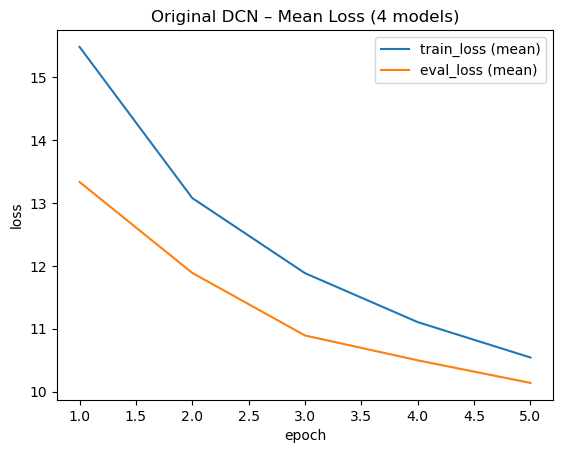

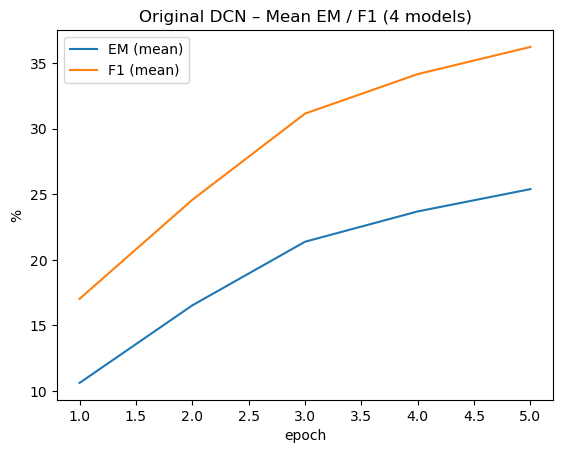

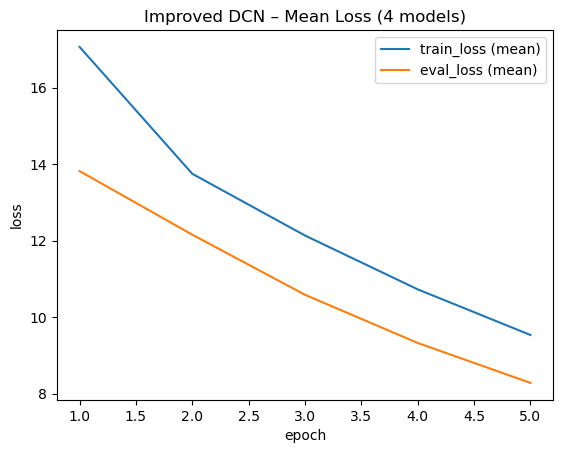

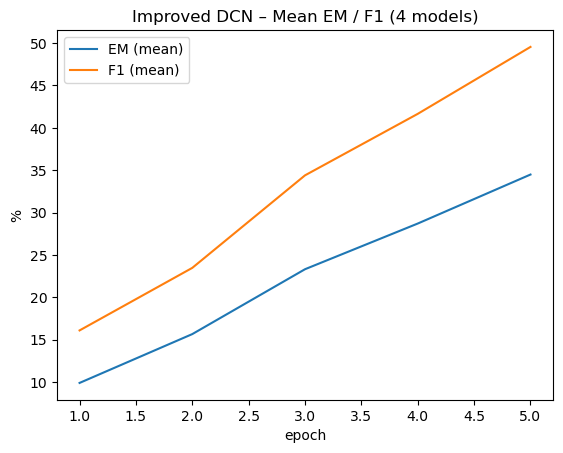

In [52]:
import numpy as np

def mean_history(histories, key):
    """
    histories: list of history dict
    key: string, e.g. 'train_loss', 'eval_loss', 'eval_em', 'eval_f1'
    returns: np.array [epochs]
    """
    values = [h[key] for h in histories]
    return np.mean(np.stack(values, axis=0), axis=0)


epochs = range(1, len(original_histories[0]["train_loss"]) + 1)

# ---- Loss
plt.figure()
plt.plot(epochs, mean_history(original_histories, "train_loss"), label="train_loss (mean)")
plt.plot(epochs, mean_history(original_histories, "eval_loss"),  label="eval_loss (mean)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Original DCN – Mean Loss (4 models)")
plt.show()

# ---- EM / F1
plt.figure()
plt.plot(epochs, mean_history(original_histories, "eval_em"), label="EM (mean)")
plt.plot(epochs, mean_history(original_histories, "eval_f1"), label="F1 (mean)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("%")
plt.title("Original DCN – Mean EM / F1 (4 models)")
plt.show()


epochs = range(1, len(improved_histories[0]["train_loss"]) + 1)

# ---- Loss
plt.figure()
plt.plot(epochs, mean_history(improved_histories, "train_loss"), label="train_loss (mean)")
plt.plot(epochs, mean_history(improved_histories, "eval_loss"),  label="eval_loss (mean)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Improved DCN – Mean Loss (4 models)")
plt.show()

# ---- EM / F1
plt.figure()
plt.plot(epochs, mean_history(improved_histories, "eval_em"), label="EM (mean)")
plt.plot(epochs, mean_history(improved_histories, "eval_f1"), label="F1 (mean)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("%")
plt.title("Improved DCN – Mean EM / F1 (4 models)")
plt.show()



In [53]:
# QUALITATIVE ANALYSIS

# Run analysis
print("========= Base Ensemble ==========")
analyze_predictions(ensemble_original, eval_loader, itos, device, num_examples=5)

print("\n")
print("========= Improved Ensemble ==========")
analyze_predictions(ensemble_improved, eval_loader, itos, device, num_examples=5)

print("\n")
print("========= Mixed Ensemble ==========")
analyze_predictions(ensemble_mixed, eval_loader, itos, device, num_examples=5)


========= Base Ensemble ==========

QUALITATIVE ANALYSIS

Example 1
Context (first 50 toks): bell 's own detailed account , presented to the american association for the advancement of science in 1882 , differs in several <unk> from most of the many and varied versions now in circulation , most notably by concluding that extraneous metal was not to blame for failure to locate...

Question: where did bell go the day after trying to find the bullet ?

 True answer: executive mansion
✓ Predicted:   executive mansion

Positions: true=[73, 74], pred=[73, 74]
Match: EXACT MATCH!
Decoder iters used: 2

Example 2
Context (first 50 toks): rome 's preoccupation with its war with carthage provided an opportunity for philip v of the kingdom of macedonia , located in the north of the greek peninsula , to attempt to extend his power westward . philip sent ambassadors to hannibal 's camp in italy , to negotiate an...

Question: what kingdom sent an ambassador to italy in an attempt to form an allianc

In [54]:
# LONGER CONTEXT + MULTIPLE QUESTIONS

context = """
Dynamic Coattention Networks (DCN) are designed for extractive question answering, meaning the model must
select an answer span directly from a provided context paragraph. The core idea is to compute attention in
both directions: from the question to the context and from the context back to the question, allowing the
model to align relevant parts of the two sequences.

In a typical pipeline, the context and question are tokenized and mapped to integer IDs using a vocabulary.
A boolean mask is built to distinguish real tokens from padding. The model then produces two distributions
over context positions: one for the start index and one for the end index of the answer span.

DCN is often combined with an iterative decoder. At each iteration, the decoder refines its prediction of
the answer span by updating an internal state. When return_all_iters=True, the model returns a list of
start logits and end logits, one pair per iteration, and the final prediction is usually taken from the
last iteration. This iterative refinement can help the model correct earlier mistakes.

However, the model cannot answer questions if the information is not present in the context. In that case,
it may still output a span, but it will likely be incorrect. This behavior is expected because the model
is trained to always select a span.
"""

questions = [
    "What does extractive question answering mean?",
    "What are the two directions of attention described?",
    "What does the model output over context positions?"
]

print("\n")
print("========= Base Ensemble ==========")
for q in questions:
    print("\n" + "="*80)
    ask(ensemble_original, context, q, return_iters=True)

print("\n")
print("========= Improved Ensemble ==========")
for q in questions:
    print("\n" + "="*80)
    ask(ensemble_improved, context, q, return_iters=True)

print("\n")
print("========= Mixed Ensemble ==========")
for q in questions:
    print("\n" + "="*80)
    ask(ensemble_mixed, context, q, return_iters=True)



========= Base Ensemble ==========

Question: What does extractive question answering mean?
Predicted answer: the model must 
 select an answer span directly from a provided context paragraph
Span: (15, 28)
Decoder iters used: 2

Question: What are the two directions of attention described?
Predicted answer: 
 dynamic coattention networks
Span: (0, 3)
Decoder iters used: 2

Question: What does the model output over context positions?
Predicted answer: two distributions 

Span: (108, 110)
Decoder iters used: 2


========= Improved Ensemble ==========

Question: What does extractive question answering mean?
Predicted answer: 
 dynamic coattention networks
Span: (0, 3)
Decoder iters used: 2

Question: What are the two directions of attention described?
Predicted answer: 
 dynamic coattention networks
Span: (0, 3)
Decoder iters used: 2

Question: What does the model output over context positions?
Predicted answer: two distributions 

Span: (108, 110)
Decoder iters used: 2


========= Mix

,Group,EM - normal (mean),EM - ensemble,F1 - normal (mean),F1 - ensemble,EM - ensemble MIXED,F1 - ensemble MIXED,Δ EM (ens - mean),Δ F1 (ens - mean),Δ EM (mixed - mean),Δ F1 (mixed - mean)
0,BASE (Original),25.39%,34.75%,36.24%,49.87%,38.47%,54.26%,+9.36 pp,+13.63 pp,+13.08 pp,+18.02 pp
1,IMPROVED,34.49%,38.30%,49.55%,54.11%,38.47%,54.26%,+3.81 pp,+4.56 pp,+3.99 pp,+4.71 pp


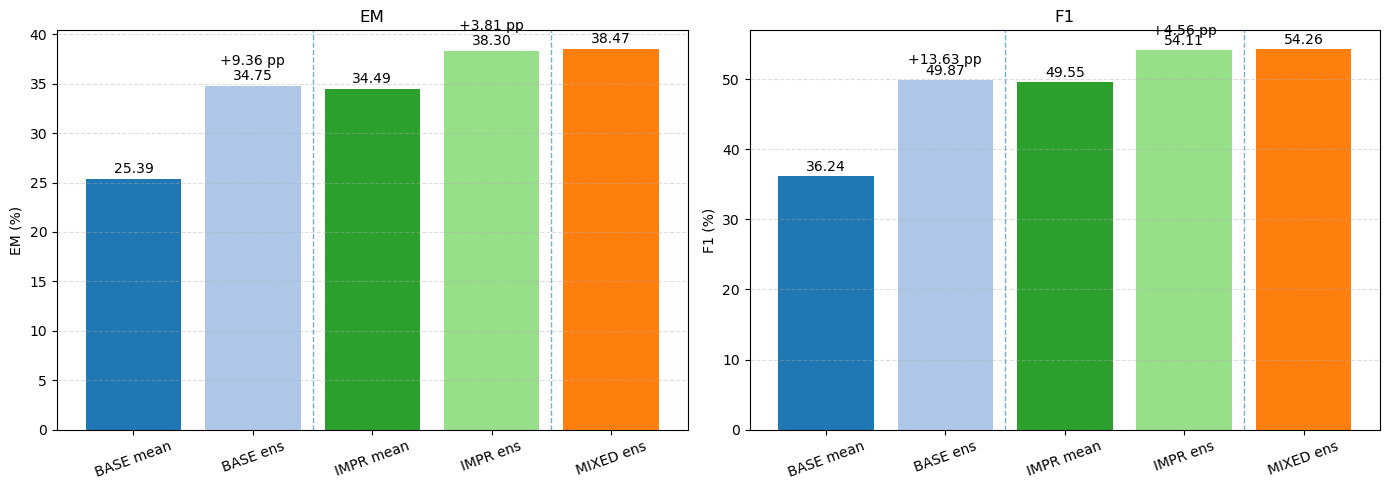

In [55]:
# COMPARISON
assert "EVAL_RESULTS" in globals(), "EVAL_RESULTS not found. Run the evaluation cell first."

def _mean_or_none(xs):
    return None if len(xs) == 0 else float(np.mean(xs))

def _fmt_pct(x):
    return "-" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.2f}%"

def _fmt_pp(x):
    return "-" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:+.2f} pp"

def _safe_delta(a, b):
    # a - b, returns None if either missing
    if a is None or b is None:
        return None
    if isinstance(a, float) and np.isnan(a):
        return None
    if isinstance(b, float) and np.isnan(b):
        return None
    return float(a - b)

def _annotate_bars(ax, bars, values, y_pad=0.6):
    """Write value labels above bars; skips NaN/None."""
    for rect, v in zip(bars, values):
        if v is None or (isinstance(v, float) and np.isnan(v)):
            continue
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height() + y_pad,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# ---- Extract means for ORIGINAL (base)
orig_inds = EVAL_RESULTS.get("original", {}).get("individual", [])
orig_mean_em = _mean_or_none([d["em"] for d in orig_inds])
orig_mean_f1 = _mean_or_none([d["f1"] for d in orig_inds])

orig_ens = EVAL_RESULTS.get("original", {}).get("ensemble", None)
orig_ens_em = None if orig_ens is None else float(orig_ens["em"])
orig_ens_f1 = None if orig_ens is None else float(orig_ens["f1"])

# ---- Extract means for IMPROVED
imp_inds = EVAL_RESULTS.get("improved", {}).get("individual", [])
imp_mean_em = _mean_or_none([d["em"] for d in imp_inds])
imp_mean_f1 = _mean_or_none([d["f1"] for d in imp_inds])

imp_ens = EVAL_RESULTS.get("improved", {}).get("ensemble", None)
imp_ens_em = None if imp_ens is None else float(imp_ens["em"])
imp_ens_f1 = None if imp_ens is None else float(imp_ens["f1"])

# ---- Extract MIXED ensemble (if present)
mix_ens = EVAL_RESULTS.get("mixed", {}).get("ensemble", None)
mix_ens_em = None if mix_ens is None else float(mix_ens["em"])
mix_ens_f1 = None if mix_ens is None else float(mix_ens["f1"])

# ---- Build comparison table + deltas
rows = [
    {
        "Group": "BASE (Original)",
        "EM - normal (mean)": orig_mean_em,
        "EM - ensemble":      orig_ens_em,
        "F1 - normal (mean)": orig_mean_f1,
        "F1 - ensemble":      orig_ens_f1,
        "EM - ensemble MIXED": mix_ens_em,
        "F1 - ensemble MIXED": mix_ens_f1,
    },
    {
        "Group": "IMPROVED",
        "EM - normal (mean)": imp_mean_em,
        "EM - ensemble":      imp_ens_em,
        "F1 - normal (mean)": imp_mean_f1,
        "F1 - ensemble":      imp_ens_f1,
        "EM - ensemble MIXED": mix_ens_em,
        "F1 - ensemble MIXED": mix_ens_f1,
    },
]

df = pd.DataFrame(rows)

# Deltas: ensemble - mean
df["Δ EM (ens - mean)"] = df["EM - ensemble"] - df["EM - normal (mean)"]
df["Δ F1 (ens - mean)"] = df["F1 - ensemble"] - df["F1 - normal (mean)"]

# Deltas for MIXED vs mean (shown for both rows: vs base mean / vs improved mean)
df["Δ EM (mixed - mean)"] = df["EM - ensemble MIXED"] - df["EM - normal (mean)"]
df["Δ F1 (mixed - mean)"] = df["F1 - ensemble MIXED"] - df["F1 - normal (mean)"]

# Pretty display
df_pretty = df.copy()
for c in [
    "EM - normal (mean)", "EM - ensemble", "F1 - normal (mean)", "F1 - ensemble",
    "EM - ensemble MIXED", "F1 - ensemble MIXED"
]:
    df_pretty[c] = df_pretty[c].apply(_fmt_pct)

for c in ["Δ EM (ens - mean)", "Δ F1 (ens - mean)", "Δ EM (mixed - mean)", "Δ F1 (mixed - mean)"]:
    df_pretty[c] = df_pretty[c].apply(lambda x: "-" if pd.isna(x) else f"{x:+.2f} pp")

display(df_pretty)


labels = ["BASE mean", "BASE ens", "IMPR mean", "IMPR ens", "MIXED ens"]

em_vals = [orig_mean_em, orig_ens_em, imp_mean_em, imp_ens_em, mix_ens_em]
f1_vals = [orig_mean_f1, orig_ens_f1, imp_mean_f1, imp_ens_f1, mix_ens_f1]

# To plot, replace None with NaN
em_plot = [np.nan if v is None else v for v in em_vals]
f1_plot = [np.nan if v is None else v for v in f1_vals]

colors = [
    "#1f77b4",  # BASE mean
    "#aec7e8",  # BASE ens
    "#2ca02c",  # IMPR mean
    "#98df8a",  # IMPR ens
    "#ff7f0e",  # MIXED ens
]

fig, (ax_em, ax_f1) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------- EM ----------
bars_em = ax_em.bar(labels, em_plot, color=colors)

ax_em.axvline(x=1.5, linestyle="--", linewidth=1, alpha=0.6)
ax_em.axvline(x=3.5, linestyle="--", linewidth=1, alpha=0.6)

#ax_em.set_ylim(20, 50)
ax_em.set_ylabel("EM (%)")
ax_em.set_title("EM")
ax_em.grid(axis="y", linestyle="--", alpha=0.4)
ax_em.tick_params(axis="x", rotation=20)

_annotate_bars(ax_em, bars_em, em_vals, y_pad=0.3)

# deltas EM
d_base_em = _safe_delta(orig_ens_em, orig_mean_em)
if d_base_em is not None:
    ax_em.text(bars_em[1].get_x() + bars_em[1].get_width()/2,
               bars_em[1].get_height() + 1.8,
               _fmt_pp(d_base_em),
               ha="center", va="bottom", fontsize=10)

d_impr_em = _safe_delta(imp_ens_em, imp_mean_em)
if d_impr_em is not None:
    ax_em.text(bars_em[3].get_x() + bars_em[3].get_width()/2,
               bars_em[3].get_height() + 1.8,
               _fmt_pp(d_impr_em),
               ha="center", va="bottom", fontsize=10)

# ---------- F1 ----------
bars_f1 = ax_f1.bar(labels, f1_plot, color=colors)

ax_f1.axvline(x=1.5, linestyle="--", linewidth=1, alpha=0.6)
ax_f1.axvline(x=3.5, linestyle="--", linewidth=1, alpha=0.6)

#ax_f1.set_ylim(35, 65)
ax_f1.set_ylabel("F1 (%)")
ax_f1.set_title("F1")
ax_f1.grid(axis="y", linestyle="--", alpha=0.4)
ax_f1.tick_params(axis="x", rotation=20)

_annotate_bars(ax_f1, bars_f1, f1_vals, y_pad=0.3)

# deltas F1
d_base_f1 = _safe_delta(orig_ens_f1, orig_mean_f1)
if d_base_f1 is not None:
    ax_f1.text(bars_f1[1].get_x() + bars_f1[1].get_width()/2,
               bars_f1[1].get_height() + 1.8,
               _fmt_pp(d_base_f1),
               ha="center", va="bottom", fontsize=10)

d_impr_f1 = _safe_delta(imp_ens_f1, imp_mean_f1)
if d_impr_f1 is not None:
    ax_f1.text(bars_f1[3].get_x() + bars_f1[3].get_width()/2,
               bars_f1[3].get_height() + 1.8,
               _fmt_pp(d_impr_f1),
               ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()
